## Dataset: Rain in Australia (Classification Problem) 

## Table of Contents
#### 1. [Business/Research Problem](#part1)
#### 2. [Project Background](#part2)
#### 3. [Problem Statement](#part3)
#### 4. [Report Objectives](#part4)
#### 5. [Metadata](#part5) 
#### 6. [Load and Explore the Datasets](#part6)  
#### 7. [Data Preprocessing, Exploration and Visualization](#part7)
#### 8. [Data Exploration and Visualization](#part8)   
#### 9. [Data Wrangling and Transformation](#part9)
   - [9.1 Descriptive Statistics](#part9.1)
   - [9.2 Correlation](#part9.2)
   - [9.3 Data Wrangling (Numerical variables)](#part9.3)
       - [9.3.1 Boxplot distributions in numerical variables](#part9.3.1)
       - [9.3.2 Yeo-Johnson transformation for numerical variables](#part9.3.2)       

#### 10. [Preparation for Deep/Machine Learning Modelling](#part10)
   - [10.1 Stratified Shuffle Split](#part10.1)
   - [10.2 Categorical Data Encoding](#part10.2)
   - [10.3 Feature Scaling: MinMax Scaler](#part10.3)
   
#### 11. [Modelling and optimising the best performing classifiers](#part11)   
   - [11.1 Artificial Neural Network](#part11.1)
   - [11.2 Decision Tree (Undersampling)](#part11.2)
   - [11.3 Support Vector Machine (Undersampling)](#part11.3)
   - [11.4 Random Forest (Undersampling)](#part11.4)
   - [11.5 Combining all classifier results](#part11.5)
   - [11.6 Confusion Matrix (All models)](#part11.6)

#### 12. [Conclusion](#part12)  

## Business/Research Problem  <a id="part1"></a>

The ability to accurately forecast rain plays a critical role in many aspects of life such as farming of crops as well as preventing excessive flooding in certain regions of the country. Therefore, there exists a need to use available historical data to create a prediction model for whether or not it will rain the next day.

## Project Background <a id="part2"></a>

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

### Source & Acknowledgements

Rain in Australia from Kaggle https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data.<br>
Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml <br>
Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/dat

## Problem Statement <a id="part3"></a>

To predict whether or not it will rain tomorrow in Australia.

## Project Objectives <a id="part4"></a>

- To develop a fully-connected and feedforward neural network for classification
- To fine tune the neural network to obtain best performance possible

## Metadata<a id="part5"></a>

1. Date: The date of observation
2. Location: The common name of the location of the weather station
3. MinTemp: The minimum temperature in degrees celsius
4. MaxTemp: The maximum temperature in degrees celsius
5. Rainfall: The amount of rainfall recorded for the day in mm
6. Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
7. Sunshine: The number of hours of bright sunshine in the day.
8. WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
9. WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
10. WindDir9am: Direction of the wind at 9am
11. WindDir3pm: Direction of the wind at 3pm
12. WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
13. WindSpeed3pm: Wind speed (km/hr) averaged over 10 minutes prior to 3pm
14. Humidity9am: Humidity (percent) at 9am
15. Humidity3pm: Humidity (percent) at 3pm
16. Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
17. Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
18. Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
19. Cloud3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cloud9am for a description of the values
20. Temp9am: Temperature (degrees C) at 9am
21. Temp3pm: Temperature (degrees C) at 3pm
22. RainToday: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
23. RainTomorrow: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

In [1]:
# import the pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import class_weight

from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    RepeatedStratifiedKFold,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder
)

from sklearn.model_selection import (
    StratifiedShuffleSplit,
    RepeatedStratifiedKFold,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
)

from tensorflow import keras
from keras import callbacks
from keras.layers import (
    Dense, 
    BatchNormalization, 
    Dropout, 
    LSTM )
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt

from feature_engine.transformation import YeoJohnsonTransformer

from feature_engine.encoding import OrdinalEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

## Load and Explore the dataset<a id="part6"></a>

### Importing Data with Pandas

#### Read in weatherAUS.csv file. Dataframe has 145,460 rows and 23 columns

In [2]:
weather_dataset = pd.read_csv("weatherAUS.csv")
weather_dataset

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

In [3]:
# Basic summary of the Rain in Australia dataset

print(weather_dataset.shape) # 145,460 rows and 23 columns
print(weather_dataset.size) # 3345,580 records
print(weather_dataset.dtypes) # 7 Categorical columns (should be 1 date-time datatype for 'date' column) and 16 numerical columns

(145460, 23)
3345580
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


### Data Preprocessing, Exploration and Visualization  <a id="part7"></a>

### Identifying Missing Values 

In [4]:
# identify any Null values in each column using df.isnull().sum()

weather_dataset.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

### Rectifying Missing Values 

In [5]:
# Get list of categorical variables
s = (weather_dataset.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [6]:
# Filling missing values with mode of the column in value

for i in object_cols:
    weather_dataset[i].fillna(weather_dataset[i].mode()[0], inplace=True)

In [7]:
# Missing values in categorical variables

for i in object_cols:
    print(i, weather_dataset[i].isnull().sum())

Date 0
Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0
RainTomorrow 0


In [8]:
# Get list of numerical variables
t = (weather_dataset.dtypes == "float64")
num_cols = list(t[t].index)

print("Numeric variables:")
print(num_cols)

Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [9]:
# Filling missing values with median of the column in value

for i in num_cols:
    weather_dataset[i].fillna(weather_dataset[i].median(), inplace=True)

In [10]:
# Missing values in categorical variables

for i in num_cols:
    print(i, weather_dataset[i].isnull().sum())

MinTemp 0
MaxTemp 0
Rainfall 0
Evaporation 0
Sunshine 0
WindGustSpeed 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
Cloud9am 0
Cloud3pm 0
Temp9am 0
Temp3pm 0


In [11]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    145460 non-null  float64
 6   Sunshine       145460 non-null  float64
 7   WindGustDir    145460 non-null  object 
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     145460 non-null  object 
 10  WindDir3pm     145460 non-null  object 
 11  WindSpeed9am   145460 non-null  float64
 12  WindSpeed3pm   145460 non-null  float64
 13  Humidity9am    145460 non-null  float64
 14  Humidity3pm    145460 non-null  float64
 15  Pressure9am    145460 non-null  float64
 16  Pressure3pm    145460 non-null  float64
 17  Cloud9am       145460 non-nul

### Data Exploration and Visualization (Exploratory Data Analysis - EDA)<a id="part8"></a>

### Univariate analysis - categorical variables

### An imbalance in the number of Non-Rainy vs. Rainy days for the target variable (RainTomorrow)

In [12]:
# check the data profile in terms of Rainy vs. Non-Rainy days value. Noted that they are imbalanced

weather_dataset["RainTomorrow"].value_counts()

RainTomorrow
No     113583
Yes     31877
Name: count, dtype: int64

In [13]:
# Group by 'RainTomorrow' and count the number of data in each category

RainTomorrow = weather_dataset.groupby(['RainTomorrow'])['RainTomorrow'].count()
RainTomorrow

RainTomorrow
No     113583
Yes     31877
Name: RainTomorrow, dtype: int64

Text(0, 0.5, 'Counts')

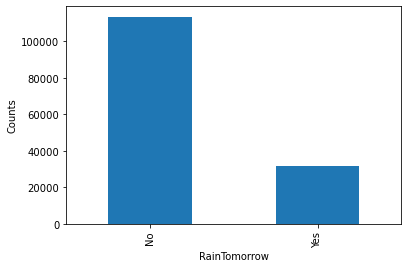

In [14]:
# Plot a bargraph for the counts 

fig = plt.figure()
ax3 = fig.add_subplot(111)

RainTomorrow.plot(kind="bar")

ax3.set_ylabel('Counts')

### Feature engineer Season column using Date (month)

In [15]:
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]

# create a user-defined function, month_to_season, that takes in a list of month as a parameter and return the season

def month_to_season(month):
    """return the season of the year"""
    if month in spring: 
        return 'spring'
    elif month in summer:
        return 'summer'
    elif month in autumn:
        return 'autumn'
    elif month in winter:
        return 'winter'

In [16]:
# convert the 'Date' column to a date-time datatype
# create a new 'month' column by extracting the month of the 'Date' column using df[].dt.month
# map the user-defined function, month_to_season, to the 'month' column of the dataset 
# and assigned it to a new 'season' column

weather_dataset['Date'] = pd.to_datetime(weather_dataset['Date'], format='%Y-%m-%d')
weather_dataset['month'] = weather_dataset['Date'].dt.month
weather_dataset['season'] = weather_dataset['month'].map(month_to_season)
weather_dataset

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          4.8       8.4   
1      2008-12-02   Albury      7.4     25.1       0.0          4.8       8.4   
2      2008-12-03   Albury     12.9     25.7       0.0          4.8       8.4   
3      2008-12-04   Albury      9.2     28.0       0.0          4.8       8.4   
4      2008-12-05   Albury     17.5     32.3       1.0          4.8       8.4   
...           ...      ...      ...      ...       ...          ...       ...   
145455 2017-06-21    Uluru      2.8     23.4       0.0          4.8       8.4   
145456 2017-06-22    Uluru      3.6     25.3       0.0          4.8       8.4   
145457 2017-06-23    Uluru      5.4     26.9       0.0          4.8       8.4   
145458 2017-06-24    Uluru      7.8     27.0       0.0          4.8       8.4   
145459 2017-06-25    Uluru     14.9     22.6       0.0          4.8       8.4   

       WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  Pressure3pm  \
0                W           44.0          W  ...      1007.7       1007.1   
1              WNW           44.0        NNW  ...      1010.6       1007.8   
2              WSW           46.0          W  ...      1007.6       1008.7   
3               NE           24.0         SE  ...      1017.6       1012.8   
4                W           41.0        ENE  ...      1010.8       1006.0   
...            ...            ...        ...  ...         ...          ...   
145455           E           31.0         SE  ...      1024.6       1020.3   
145456         NNW           22.0         SE  ...      1023.5       1019.1   
145457           N           37.0         SE  ...      1021.0       1016.8   
145458          SE           28.0        SSE  ...      1019.4       1016.5   
145459           W           39.0        ESE  ...      1020.2       1017.9   

        Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  month  \
0            8.0       5.0     16.9     21.8         No            No     12   
1            5.0       5.0     17.2     24.3         No            No     12   
2            5.0       2.0     21.0     23.2         No            No     12   
3            5.0       5.0     18.1     26.5         No            No     12   
4            7.0       8.0     17.8     29.7         No            No     12   
...          ...       ...      ...      ...        ...           ...    ...   
145455       5.0       5.0     10.1     22.4         No            No      6   
145456       5.0       5.0     10.9     24.5         No            No      6   
145457       5.0       5.0     12.5     26.1         No            No      6   
145458       3.0       2.0     15.1     26.0         No            No      6   
145459       8.0       8.0     15.0     20.9         No            No      6   

        season  
0       winter  
1       winter  
2       winter  
3       winter  
4       winter  
...        ...  
145455  summer  
145456  summer  
145457  summer  
145458  summer  
145459  summer  

[145460 rows x 25 columns]

### Data Wrangling and Transformation<a id="part9"></a>

In [17]:
# Drop those columns that are unnecessary for further analysis
# Convert 'yes' to 1 and 'no' to 0 in the 'RainToday' and 'RainTomorrow' columns

weather_dataset.drop(['Date', 'month'], axis=1, inplace=True)
weather_dataset["RainToday"] = weather_dataset["RainToday"].map({'Yes': 1, 'No': 0})
weather_dataset["RainTomorrow"] = weather_dataset["RainTomorrow"].map({'Yes': 1, 'No': 0})
weather_dataset

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury     13.4     22.9       0.6          4.8       8.4   
1        Albury      7.4     25.1       0.0          4.8       8.4   
2        Albury     12.9     25.7       0.0          4.8       8.4   
3        Albury      9.2     28.0       0.0          4.8       8.4   
4        Albury     17.5     32.3       1.0          4.8       8.4   
...         ...      ...      ...       ...          ...       ...   
145455    Uluru      2.8     23.4       0.0          4.8       8.4   
145456    Uluru      3.6     25.3       0.0          4.8       8.4   
145457    Uluru      5.4     26.9       0.0          4.8       8.4   
145458    Uluru      7.8     27.0       0.0          4.8       8.4   
145459    Uluru     14.9     22.6       0.0          4.8       8.4   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
0                W           44.0          W        WNW  ...         22.0   
1              WNW           44.0        NNW        WSW  ...         25.0   
2              WSW           46.0          W        WSW  ...         30.0   
3               NE           24.0         SE          E  ...         16.0   
4                W           41.0        ENE         NW  ...         33.0   
...            ...            ...        ...        ...  ...          ...   
145455           E           31.0         SE        ENE  ...         24.0   
145456         NNW           22.0         SE          N  ...         21.0   
145457           N           37.0         SE        WNW  ...         24.0   
145458          SE           28.0        SSE          N  ...         24.0   
145459           W           39.0        ESE        ESE  ...         36.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       5.0     16.9     21.8   
1            1010.6       1007.8       5.0       5.0     17.2     24.3   
2            1007.6       1008.7       5.0       2.0     21.0     23.2   
3            1017.6       1012.8       5.0       5.0     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145455       1024.6       1020.3       5.0       5.0     10.1     22.4   
145456       1023.5       1019.1       5.0       5.0     10.9     24.5   
145457       1021.0       1016.8       5.0       5.0     12.5     26.1   
145458       1019.4       1016.5       3.0       2.0     15.1     26.0   
145459       1020.2       1017.9       8.0       8.0     15.0     20.9   

        RainToday  RainTomorrow  season  
0               0             0  winter  
1               0             0  winter  
2               0             0  winter  
3               0             0  winter  
4               0             0  winter  
...           ...           ...     ...  
145455          0             0  summer  
145456          0             0  summer  
145457          0             0  summer  
145458          0             0  summer  
145459          0             0  summer  

[145460 rows x 23 columns]

###  Descriptive statistics<a id="part9.1"></a>

In [18]:
# Use descriptive statistics to check if there are anything amiss in each numerical column. 
# All variables seem ok at the moment

weather_dataset.describe()

MinTemp        MaxTemp       Rainfall    Evaporation  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean       12.192053      23.215962       2.307990       5.179779   
std         6.365780       7.088358       8.389771       3.178819   
min        -8.500000      -4.800000       0.000000       0.000000   
25%         7.700000      18.000000       0.000000       4.000000   
50%        12.000000      22.600000       0.000000       4.800000   
75%        16.800000      28.200000       0.600000       5.200000   
max        33.900000      48.100000     371.000000     145.000000   

            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        7.989889      39.962189      14.030751      18.669758   
std         2.757790      13.120931       8.861796       8.716716   
min         0.000000       6.000000       0.000000       0.000000   
25%         8.200000      31.000000       7.000000      13.000000   
50%         8.400000      39.000000      13.000000      19.000000   
75%         8.700000      46.000000      19.000000      24.000000   
max        14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm    Pressure9am    Pressure3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean       68.901251      51.553396    1017.644768    1015.250115   
std        18.855360      20.471345       6.728484       6.663994   
min         0.000000       0.000000     980.500000     977.100000   
25%        57.000000      37.000000    1013.500000    1011.100000   
50%        70.000000      52.000000    1017.600000    1015.200000   
75%        83.000000      65.000000    1021.800000    1019.400000   
max       100.000000     100.000000    1041.000000    1039.600000   

            Cloud9am       Cloud3pm        Temp9am        Temp3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        4.659755       4.709913      16.987101      21.668916   
std         2.281490       2.106768       6.449299       6.850658   
min         0.000000       0.000000      -7.200000      -5.400000   
25%         3.000000       4.000000      12.300000      16.700000   
50%         5.000000       5.000000      16.700000      21.100000   
75%         6.000000       6.000000      21.500000      26.200000   
max         9.000000       9.000000      40.200000      46.700000   

           RainToday   RainTomorrow  
count  145460.000000  145460.000000  
mean        0.219167       0.219146  
std         0.413683       0.413669  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

###  Correlation <a id="part9.2"></a>

In [19]:
# Use correlation to check if there are features that are highly correlated to each other

weather_dataset[num_cols].corr()

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
MinTemp        1.000000  0.733358  0.102339     0.364798  0.032632   
MaxTemp        0.733358  1.000000 -0.073563     0.447289  0.315487   
Rainfall       0.102339 -0.073563  1.000000    -0.041371 -0.168777   
Evaporation    0.364798  0.447289 -0.041371     1.000000  0.279210   
Sunshine       0.032632  0.315487 -0.168777     0.279210  1.000000   
WindGustSpeed  0.171899  0.066451  0.125109     0.149942 -0.031229   
WindSpeed9am   0.173513  0.014389  0.084586     0.148681 -0.012197   
WindSpeed3pm   0.173055  0.049507  0.055688     0.101264  0.023176   
Humidity9am   -0.231310 -0.498350  0.220661    -0.384284 -0.330031   
Humidity3pm    0.006111 -0.498725  0.247946    -0.293638 -0.430357   
Pressure9am   -0.423299 -0.308057 -0.158812    -0.213660  0.035759   
Pressure3pm   -0.432824 -0.396339 -0.119397    -0.233593 -0.010618   
Cloud9am       0.043056 -0.232311  0.164202    -0.169494 -0.505488   
Cloud3pm       0.000157 -0.218368  0.139380    -0.160652 -0.526045   
Temp9am        0.897829  0.879335  0.010933     0.425712  0.191385   
Temp3pm        0.698574  0.968332 -0.077466     0.434014  0.331676   

               WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
MinTemp             0.171899      0.173513      0.173055    -0.231310   
MaxTemp             0.066451      0.014389      0.049507    -0.498350   
Rainfall            0.125109      0.084586      0.055688     0.220661   
Evaporation         0.149942      0.148681      0.101264    -0.384284   
Sunshine           -0.031229     -0.012197      0.023176    -0.330031   
WindGustSpeed       1.000000      0.578744      0.657975    -0.208803   
WindSpeed9am        0.578744      1.000000      0.512279    -0.268196   
WindSpeed3pm        0.657975      0.512279      1.000000    -0.143358   
Humidity9am        -0.208803     -0.268196     -0.143358     1.000000   
Humidity3pm        -0.026804     -0.031079      0.016275     0.659290   
Pressure9am        -0.425819     -0.215107     -0.277277     0.131418   
Pressure3pm        -0.384140     -0.165124     -0.239274     0.175914   
Cloud9am            0.046261      0.006593      0.031498     0.355815   
Cloud3pm            0.072894      0.028376      0.010460     0.278105   
Temp9am             0.145717      0.127491      0.161040    -0.469774   
Temp3pm             0.032375      0.004806      0.027529    -0.491242   

               Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
MinTemp           0.006111    -0.423299    -0.432824  0.043056  0.000157   
MaxTemp          -0.498725    -0.308057    -0.396339 -0.232311 -0.218368   
Rainfall          0.247946    -0.158812    -0.119397  0.164202  0.139380   
Evaporation      -0.293638    -0.213660    -0.233593 -0.169494 -0.160652   
Sunshine         -0.430357     0.035759    -0.010618 -0.505488 -0.526045   
WindGustSpeed    -0.026804    -0.425819    -0.384140  0.046261  0.072894   
WindSpeed9am     -0.031079    -0.215107    -0.165124  0.006593  0.028376   
WindSpeed3pm      0.016275    -0.277277    -0.239274  0.031498  0.010460   
Humidity9am       0.659290     0.131418     0.175914  0.355815  0.278105   
Humidity3pm       1.000000    -0.025986     0.048527  0.396914  0.403456   
Pressure9am      -0.025986     1.000000     0.959663 -0.095632 -0.107923   
Pressure3pm       0.048527     0.959663     1.000000 -0.042064 -0.060035   
Cloud9am          0.396914    -0.095632    -0.042064  1.000000  0.562446   
Cloud3pm          0.403456    -0.107923    -0.060035  0.562446  1.000000   
Temp9am          -0.216951    -0.396885    -0.441184 -0.122161 -0.110757   
Temp3pm          -0.555606    -0.265026    -0.360083 -0.238197 -0.253149   

                Temp9am   Temp3pm  
MinTemp        0.897829  0.698574  
MaxTemp        0.879335  0.968332  
Rainfall       0.010933 -0.077466  
Evaporation    0.425712  0.434014  
Sunshine       0.191385  0.331676  
WindGustSpeed  0.145717  0.032375  
WindSpeed9am   0.127491  0.004806  
Wi

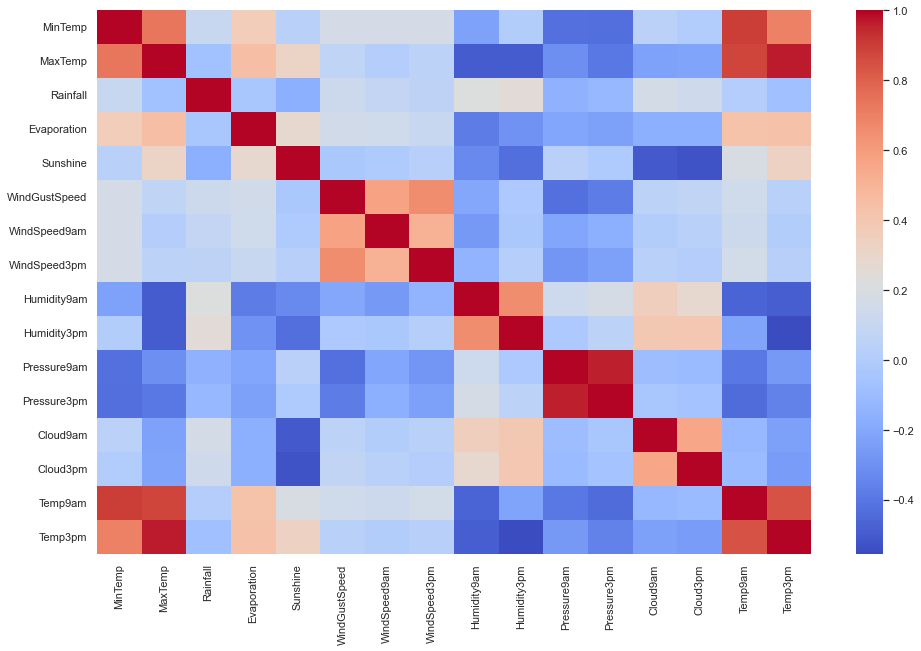

In [20]:
#  Within each categories "Temp", "WindSpeed", "Humidity", "Pressure", "Cloud", they are all highly correlated to each other
# 'Humidity3pm' seemed to be correlated with "RainTomorrow" target variable

sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(weather_dataset[num_cols].corr(), cmap = 'coolwarm', annot=False)
plt.show()

### Data Wrangling (Numerical variables)<a id="part9.3"></a>
One way to look at the distributions of numerical variables is by plotting histograms    

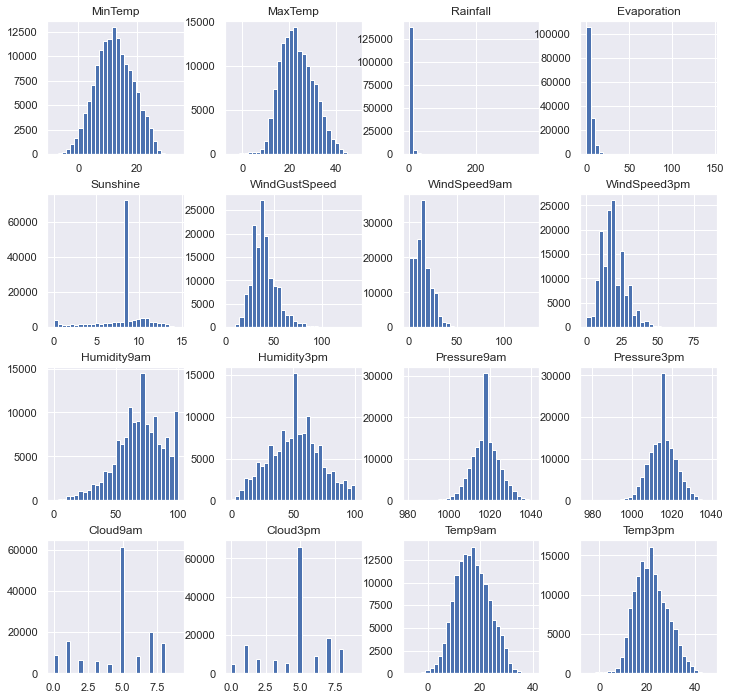

In [21]:
# plot histograms of the num variables

weather_dataset[num_cols].hist(bins=30, figsize=(12,12))
plt.show()

### Boxplot distributions in numerical variables <a id="part9.3.1"></a>

Boxplots are another way to visualize the distributions of numerical variables, which shows the median, the 25th and 75th percentile values, as well as the presence of outliers

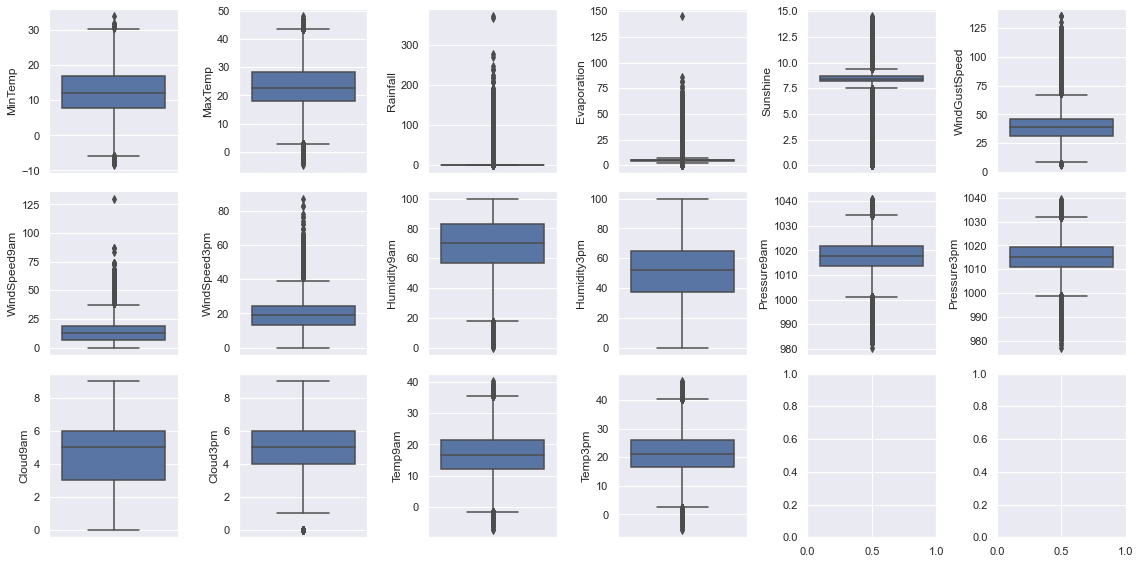

In [22]:
fig, ax = plt.subplots(3, 6, figsize=(16, 8))
sns.set(font_scale = 1)
sns.boxplot(y= weather_dataset['MinTemp'], ax=ax[0,0])
sns.boxplot(y= weather_dataset['MaxTemp'], ax=ax[0,1])
sns.boxplot(y = weather_dataset['Rainfall'], ax=ax[0,2])
sns.boxplot(y = weather_dataset['Evaporation'], ax=ax[0,3])
sns.boxplot(y = weather_dataset['Sunshine'], ax=ax[0,4])
sns.boxplot(y = weather_dataset['WindGustSpeed'], ax=ax[0,5])
sns.boxplot(y = weather_dataset['WindSpeed9am'], ax=ax[1,0])
sns.boxplot(y = weather_dataset['WindSpeed3pm'], ax=ax[1,1])
sns.boxplot(y = weather_dataset['Humidity9am'], ax=ax[1,2])
sns.boxplot(y = weather_dataset['Humidity3pm'], ax=ax[1,3])
sns.boxplot(y = weather_dataset['Pressure9am'], ax=ax[1,4])
sns.boxplot(y = weather_dataset['Pressure3pm'], ax=ax[1,5])
sns.boxplot(y = weather_dataset['Cloud9am'], ax=ax[2,0])
sns.boxplot(y = weather_dataset['Cloud3pm'], ax=ax[2,1])
sns.boxplot(y = weather_dataset['Temp9am'], ax=ax[2,2])
sns.boxplot(y = weather_dataset['Temp3pm'], ax=ax[2,3])
plt.tight_layout()

### Yeo-Johnson transformation for numerical variables <a id="part9.3.2"></a>

Since most of the distributions of numerical variables are not normally distributed, which is a requirement for most predictive models, perform Yeo-Johnson transformation on them. The Yeo-Johnson transformation is an extension of the Box-Cox transformation and can be used on variables with zero and negative values, as well as positive values. Yeo-Johnson transformation is especially useful here because most of the variables have zero and negative values, of which power transformation, log transformation and box-cox transformation could not be performed across the entire dataset.

In [23]:
# initialize the transformer with the numerical variables to transform 

yjt = YeoJohnsonTransformer(variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', \
                                         'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', \
                                         'Pressure3pm', 'Cloud9am', 'Temp9am', 'Temp3pm'])

# fit transformer 

yjt.fit(weather_dataset)

# transform indicated variables in the dataset

weather_dataset_tf = yjt.transform(weather_dataset)

In [24]:
# checking the transformed numerical columns 

weather_dataset_tf

Location    MinTemp    MaxTemp  Rainfall  Evaporation   Sunshine  \
0        Albury  12.147439  14.694465  0.324172     2.039069  25.972432   
1        Albury   6.868868  15.862912 -0.000000     2.039069  25.972432   
2        Albury  11.712843  16.178162 -0.000000     2.039069  25.972432   
3        Albury   8.468678  17.374055 -0.000000     2.039069  25.972432   
4        Albury  15.683339  19.561432  0.408066     2.039069  25.972432   
...         ...        ...        ...       ...          ...        ...   
145455    Uluru   2.682795  14.961814 -0.000000     2.039069  25.972432   
145456    Uluru   3.424363  15.968152 -0.000000     2.039069  25.972432   
145457    Uluru   5.069527  16.804528 -0.000000     2.039069  25.972432   
145458    Uluru   7.225827  16.856483 -0.000000     2.039069  25.972432   
145459    Uluru  13.446549  14.533528 -0.000000     2.039069  25.972432   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
0                W       6.202203          W        WNW  ...    17.283746   
1              WNW       6.202203        NNW        WSW  ...    19.412371   
2              WSW       6.310586          W        WSW  ...    22.903249   
3               NE       4.842350         SE          E  ...    12.931149   
4                W       6.032536        ENE         NW  ...    24.968238   
...            ...            ...        ...        ...  ...          ...   
145455           E       5.390337         SE        ENE  ...    18.705915   
145456         NNW       4.664428         SE          N  ...    16.567738   
145457           N       5.791321         SE        WNW  ...    18.705915   
145458          SE       5.167941        SSE          N  ...    18.705915   
145459           W       5.914225        ESE        ESE  ...    27.013743   

         Pressure9am   Pressure3pm   Cloud9am  Cloud3pm    Temp9am    Temp3pm  \
0       4.520339e+14  3.326199e+08  12.872059       5.0  14.251589  14.785368   
1       4.587206e+14  3.333124e+08   7.244392       5.0  14.487033  16.219592   
2       4.518047e+14  3.342041e+08   7.244392       2.0  17.442975  15.591737   
3       4.751894e+14  3.382864e+08   7.244392       5.0  15.191439  17.461272   
4       4.591847e+14  3.315338e+08  10.918654       8.0  14.956953  19.236955   
...              ...           ...        ...       ...        ...        ...   
145455  4.921304e+14  3.458397e+08   7.244392       5.0   8.811470  15.131984   
145456  4.894366e+14  3.446237e+08   7.244392       5.0   9.463490  16.333229   
145457  4.833583e+14  3.423010e+08   7.244392       5.0  10.756790  17.236843   
145458  4.795001e+14  3.419988e+08   3.939690       2.0  12.831757  17.180646   
145459  4.814261e+14  3.434105e+08  12.872059       8.0  12.752500  14.262431   

        RainToday  RainTomorrow  season  
0               0             0  winter  
1               0             0  winter  
2               0             0  winter  
3               0             0  winter  
4               0             0  winter  
...           ...           ...     ...  
145455          0             0  summer  
145456          0             0  summer  
145457          0             0  summer  
145458          0             0  summer  
145459          0             0  summer  

[145460 rows x 23 columns]

### Preparation for Deep/Machine Learning Modelling<a id="part10"></a>

In [25]:
# in percentage
weather_dataset_tf["RainTomorrow"].value_counts(normalize=True)

RainTomorrow
0    0.780854
1    0.219146
Name: proportion, dtype: float64

Data is skewed at ~78% towards Non-Hits tracks which will be an important factor to consider when evaluating the trained model <br>
Given the skewness in the target variable, the data is split into the training and test sets which are stratified by the `RainTomorrow` values (target labels) <br>
`StratefiedShuffleSplit()` will be used, instead of `train_test_split()` which does the split proportionately

### Stratified Shuffle Split<a id="part10.1"></a>

As the dataset is imbalanced, the stratified train/test split method is used to divide the dataset into the 70% training and 30% test sets

In [26]:
# Split dataset using StratifiedShuffleSplit. Provides train/test indices to split data in train/test sets.
# This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. 
# The folds are made by preserving the percentage of samples for each class.

# Separate feature columns and the target column
feature_cols = [x for x in weather_dataset_tf.columns if x != 'RainTomorrow']
feature_cols  # exclude RainTomorrow col

['Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'season']

In [27]:
#initialization a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)

In [28]:
# split data folders based on Hits value, to ensure the good distribution of train and test data responding to Hits values
# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(weather_dataset_tf[feature_cols], weather_dataset_tf['RainTomorrow']))

In [29]:
train_idx, test_idx

(array([ 20539, 121567,  53830, ...,  27125,  24224,  46855], dtype=int64),
 array([119703,  38202,  35231, ..., 103549,  20548,  61027], dtype=int64))

In [30]:
# create training and test dataset using train_idx, test_idx
# DataFrame.iloc: Access a group of rows by index 
# DataFrame.iloc: Access a group of columns by labels

X_train = weather_dataset_tf[feature_cols].iloc[train_idx] 
y_train = weather_dataset_tf['RainTomorrow'].iloc[train_idx]

X_test = weather_dataset_tf[feature_cols].iloc[test_idx]
y_test = weather_dataset_tf['RainTomorrow'].iloc[test_idx]

In [31]:
X_train.head(10)

Location    MinTemp    MaxTemp  Rainfall  Evaporation   Sunshine  \
20539     NorahHead  17.392510  17.063941 -0.000000     2.039069  25.972432   
121567        Perth  15.683339  21.546656 -0.000000     2.858110  51.702710   
53830   MountGinini   6.600560  11.049716 -0.000000     2.039069  25.972432   
106086      Woomera   5.702275  11.106777 -0.000000     1.557500  25.972432   
55787      Ballarat   3.884300   9.127276  0.508377     2.039069  25.972432   
135051   Launceston   6.511008  11.106777  0.576017     2.039069  25.972432   
1661         Albury   7.136669   9.482916  0.538821     2.039069  25.972432   
68640     Melbourne   9.438812   9.894220  0.256540     1.122166   0.000000   
36789    WaggaWagga   8.557092  12.956063  0.574797     1.122166  13.595636   
92388     GoldCoast  19.855378  18.855724 -0.000000     2.039069  25.972432   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
20539          NNE       6.517225        ENE         NE  ...   384.019137   
121567         ENE       5.914225          E         NE  ...   178.497190   
53830            W       7.396688        WNW        WSW  ...   343.653393   
106086         SSW       6.146631         SW        SSW  ...   451.612385   
55787            W       6.202203          W          W  ...   645.416797   
135051         NNW       7.027974         NW        NNW  ...   578.294542   
1661            SE       5.318039         SE        ESE  ...   597.222696   
68640            N       6.711867         NE        NNE  ...   425.841131   
36789          WSW       6.310586        WSW        NNW  ...   522.736909   
92388          SSE       5.390337        SSE          E  ...   351.607467   

        Humidity3pm   Pressure9am   Pressure3pm   Cloud9am  Cloud3pm  \
20539     49.852570  4.749508e+14  3.400890e+08   7.244392       5.0   
121567    17.996421  4.666614e+14  3.349980e+08   0.000000       0.0   
53830     33.049489  4.751894e+14  3.406913e+08   7.244392       5.0   
106086    33.049489  4.928672e+14  3.499137e+08   1.130645       6.0   
55787     54.879544  4.701996e+14  3.416968e+08  12.872059       8.0   
135051    44.765174  4.751894e+14  3.406913e+08  12.872059       4.0   
1661      67.223394  4.636123e+14  3.323235e+08  10.918654       7.0   
68640     48.586681  4.749508e+14  3.362909e+08  12.872059       5.0   
36789     40.904971  4.848115e+14  3.448262e+08  12.872059       1.0   
92388     47.316904  4.550216e+14  3.322247e+08   7.244392       5.0   

          Temp9am    Temp3pm  RainToday  season  
20539   20.280061  15.649018          0  autumn  
121567  19.822453  22.322650          0  winter  
53830   10.354088  10.422239          0  winter  
106086   8.811470  11.160649          0  summer  
55787    6.495938   8.012452          1  autumn  
135051  11.158244  10.731082          1  autumn  
1661     9.463490   8.914209          1  autumn  
68640   10.515322  10.049317          0  summer  
36789    9.300839  12.908451          1  autumn  
92388   23.760214  18.851407          0  winter  

[10 rows x 22 columns]

In [32]:
y_train.head(10)

20539     0
121567    0
53830     0
106086    0
55787     0
135051    1
1661      1
68640     1
36789     0
92388     0
Name: RainTomorrow, dtype: int64

In [33]:
# Now check the number of each target label in the training and test sets
print('Training data:\n', y_train.value_counts())
print('\nTest data:\n',   y_test.value_counts())

Training data:
 RainTomorrow
0    79508
1    22314
Name: count, dtype: int64

Test data:
 RainTomorrow
0    34075
1     9563
Name: count, dtype: int64


In [34]:
# train data has similiar distribution profile as Hits data
print('Training data:\n', y_train.value_counts(normalize=True))  #in percentage
print('\nTest data:\n',   y_test.value_counts(normalize=True))    #in percentage

Training data:
 RainTomorrow
0    0.780853
1    0.219147
Name: proportion, dtype: float64

Test data:
 RainTomorrow
0    0.780856
1    0.219144
Name: proportion, dtype: float64


### Categorical Data Encoding<a id="part10.2"></a>

In [35]:
# find all categorical variables 

cat_cols = [c for c in X_train.columns if X_train[c].dtypes=='O'] 
X_train[cat_cols].head()

Location WindGustDir WindDir9am WindDir3pm  season
20539     NorahHead         NNE        ENE         NE  autumn
121567        Perth         ENE          E         NE  winter
53830   MountGinini           W        WNW        WSW  winter
106086      Woomera         SSW         SW        SSW  summer
55787      Ballarat           W          W          W  autumn

In [36]:
# check for cardinality for all categorical variables

X_train[cat_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
season          4
dtype: int64

### Ordinal/Label encoding for Categorical variables

Since Location, WindGustDir, WindDir9am, WindDir3pm and season variables have high cardinality, Ordinal/Label encoding is more suitable to be used here for these variables

In [37]:
# create a list of categorical columns to be transformed by Ordinal encoding

ordinal_cat_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'season']

In [38]:
# pass in the list of categorical columns to be transformed by Ordinal encoding

ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=ordinal_cat_cols)

In [39]:
# Fit the encoder to the train set

ordinal_enc.fit(X_train, y_train)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
                          'season'])

In [40]:
# Inspect which variables the encoder will encode

ordinal_enc.variables

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'season']

In [41]:
# Observe the numbers assigned to each category for all the indicated variables

ordinal_enc.encoder_dict_

{'Location': {'NorahHead': 0,
  'Perth': 1,
  'MountGinini': 2,
  'Woomera': 3,
  'Ballarat': 4,
  'Launceston': 5,
  'Albury': 6,
  'Melbourne': 7,
  'WaggaWagga': 8,
  'GoldCoast': 9,
  'Newcastle': 10,
  'Uluru': 11,
  'MountGambier': 12,
  'Nuriootpa': 13,
  'Portland': 14,
  'Katherine': 15,
  'Penrith': 16,
  'Cobar': 17,
  'Bendigo': 18,
  'Darwin': 19,
  'Brisbane': 20,
  'Richmond': 21,
  'PerthAirport': 22,
  'Dartmoor': 23,
  'CoffsHarbour': 24,
  'AliceSprings': 25,
  'Williamtown': 26,
  'Cairns': 27,
  'Sydney': 28,
  'PearceRAAF': 29,
  'Mildura': 30,
  'Watsonia': 31,
  'Townsville': 32,
  'Nhil': 33,
  'Adelaide': 34,
  'MelbourneAirport': 35,
  'Canberra': 36,
  'Albany': 37,
  'Wollongong': 38,
  'BadgerysCreek': 39,
  'Moree': 40,
  'Sale': 41,
  'SalmonGums': 42,
  'Witchcliffe': 43,
  'NorfolkIsland': 44,
  'Hobart': 45,
  'Walpole': 46,
  'Tuggeranong': 47,
  'SydneyAirport': 48},
 'WindGustDir': {'NNE': 0,
  'ENE': 1,
  'W': 2,
  'SSW': 3,
  'NNW': 4,
  'SE': 5,

In [42]:
# transform train and test

X_train_tf_ord_enc = ordinal_enc.transform(X_train)
X_test_tf_ord_enc = ordinal_enc.transform(X_test)

In [43]:
X_train_tf_ord_enc

Location    MinTemp    MaxTemp  Rainfall  Evaporation   Sunshine  \
20539          0  17.392510  17.063941 -0.000000     2.039069  25.972432   
121567         1  15.683339  21.546656 -0.000000     2.858110  51.702710   
53830          2   6.600560  11.049716 -0.000000     2.039069  25.972432   
106086         3   5.702275  11.106777 -0.000000     1.557500  25.972432   
55787          4   3.884300   9.127276  0.508377     2.039069  25.972432   
...          ...        ...        ...       ...          ...        ...   
80198         31   8.910301  13.831400  0.558901     1.122166  14.345750   
19147          0  16.880727  15.281216 -0.000000     2.039069  25.972432   
27125         16  11.886779  13.777062  0.372376     2.039069  25.972432   
24224         16  12.841144  18.398845 -0.000000     2.039069  25.972432   
46855         36   0.297837  13.559226 -0.000000     2.039069  15.111716   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  \
20539             0       6.517225           0           0  ...   384.019137   
121567            1       5.914225           1           0  ...   178.497190   
53830             2       7.396688           2           1  ...   343.653393   
106086            3       6.146631           3           2  ...   451.612385   
55787             2       6.202203           4           3  ...   645.416797   
...             ...            ...         ...         ...  ...          ...   
80198             3       6.711867          11           4  ...   665.038486   
19147            15       6.805169          10           0  ...   513.659274   
27125            13       5.167941          14           9  ...   392.268706   
24224            14       4.842350          14           4  ...   400.576092   
46855             6       6.146631          11           4  ...   550.283548   

        Humidity3pm   Pressure9am   Pressure3pm   Cloud9am  Cloud3pm  \
20539     49.852570  4.749508e+14  3.400890e+08   7.244392       5.0   
121567    17.996421  4.666614e+14  3.349980e+08   0.000000       0.0   
53830     33.049489  4.751894e+14  3.406913e+08   7.244392       5.0   
106086    33.049489  4.928672e+14  3.499137e+08   1.130645       6.0   
55787     54.879544  4.701996e+14  3.416968e+08  12.872059       8.0   
...             ...           ...           ...        ...       ...   
80198     38.307838  4.664262e+14  3.363905e+08  12.872059       3.0   
19147     58.614192  4.742357e+14  3.396879e+08   7.244392       5.0   
27125     37.655380  4.751894e+14  3.406913e+08   7.244392       5.0   
24224     30.384233  4.751894e+14  3.406913e+08   7.244392       5.0   
46855     33.049489  4.848115e+14  3.399887e+08   7.244392       7.0   

          Temp9am    Temp3pm  RainToday  season  
20539   20.280061  15.649018          0       0  
121567  19.822453  22.322650          0       1  
53830   10.354088  10.422239          0       1  
106086   8.811470  11.160649          0       2  
55787    6.495938   8.012452          1       0  
...           ...        ...        ...     ...  
80198   11.718275  13.618146          1       3  
19147   18.597616  15.247176          0       0  
27125   13.858444  14.204097          0       3  
24224   16.126354  18.408849          0       3  
46855    6.830304  13.145838          0       3  

[101822 rows x 22 columns]

In [44]:
X_train_tf_ord_enc.isnull().sum() 

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
season           0
dtype: int64

In [45]:
X_test_tf_ord_enc.isnull().sum() 

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
season           0
dtype: int64

### Feature Scaling: MinMax Scaler<a id="part10.3"></a>

In order to reduce the impact of feature scale and magnitude on the performance of Classifier models (is. SVM), there is a need to perform scaling for the dataset.  Feature Scaling using MinMax Scaler can be used here to scale all the variables. Scaling to the minimum and maximum values squeezes the values of the variables between 0 and 1. To implement this scaling technique, the minimum value are substracted from all the observations and divide the result by the value range, that is, the difference between the maximum and minimum values:

\begin{equation}
x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}
\end{equation}

In [46]:
# set up the scaler

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters

scaler.fit(X_train_tf_ord_enc)

# transform train and test sets

X_train_scaled = scaler.transform(X_train_tf_ord_enc)
X_test_scaled = scaler.transform(X_test_tf_ord_enc)

In [47]:
# Transform the returned NumPy arrays to dataframes

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_tf_ord_enc.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_tf_ord_enc.columns)

In [48]:
# check all the transformed variables in the X_train_scaled dataset

X_train_scaled

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0       0.000000  0.687623  0.686020  0.000000     0.319504  0.431251   
1       0.020833  0.643451  0.825174  0.000000     0.447840  0.858481   
2       0.041667  0.408716  0.499325  0.000000     0.319504  0.431251   
3       0.062500  0.385501  0.501096  0.000000     0.244046  0.431251   
4       0.083333  0.338518  0.439648  0.860356     0.319504  0.431251   
...          ...       ...       ...       ...          ...       ...   
101817  0.645833  0.468409  0.585675  0.945860     0.175833  0.238199   
101818  0.000000  0.674397  0.630680  0.000000     0.319504  0.431251   
101819  0.333333  0.545333  0.583988  0.630194     0.319504  0.431251   
101820  0.333333  0.569998  0.727459  0.000000     0.319504  0.431251   
101821  0.750000  0.245829  0.577226  0.000000     0.319504  0.250918   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  \
0          0.000000       0.588711    0.000000    0.000000  ...     0.577439   
1          0.066667       0.500861    0.066667    0.000000  ...     0.268401   
2          0.133333       0.716840    0.133333    0.066667  ...     0.516742   
3          0.200000       0.534720    0.200000    0.133333  ...     0.679077   
4          0.133333       0.542816    0.266667    0.200000  ...     0.970495   
...             ...            ...         ...         ...  ...          ...   
101817     0.200000       0.617069    0.733333    0.266667  ...     1.000000   
101818     1.000000       0.630662    0.666667    0.000000  ...     0.772375   
101819     0.866667       0.392136    0.933333    0.600000  ...     0.589844   
101820     0.933333       0.344701    0.933333    0.266667  ...     0.602335   
101821     0.400000       0.534720    0.733333    0.266667  ...     0.827446   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am  \
0          0.734929     0.582183     0.578165  0.562800  0.555556  0.708813   
1          0.265304     0.523258     0.494610  0.000000  0.000000  0.697288   
2          0.487217     0.583878     0.588050  0.562800  0.555556  0.458820   
3          0.487217     0.709540     0.739408  0.087837  0.666667  0.419968   
4          0.809037     0.548409     0.604551  1.000000  0.888889  0.361650   
...             ...          ...          ...       ...       ...       ...   
101817     0.564736     0.521587     0.517463  1.000000  0.333333  0.493178   
101818     0.864093     0.577099     0.571581  0.562800  0.555556  0.666439   
101819     0.555117     0.583878     0.588050  0.562800  0.555556  0.547080   
101820     0.447926     0.583878     0.588050  0.562800  0.555556  0.604199   
101821     0.487217     0.652276     0.576518  0.562800  0.777778  0.370071   

         Temp3pm  RainToday    season  
0       0.640531        0.0  0.000000  
1       0.835542        0.0  0.333333  
2       0.487799        0.0  0.333333  
3       0.509376        0.0  0.666667  
4       0.417382        1.0  0.000000  
...          ...        ...       ...  
101817  0.581187        1.0  1.000000  
101818  0.628789        0.0  0.000000  
101819  0.598309        0.0  1.000000  
101820  0.721177        0.0  1.000000  
101821  0.567386        0.0  1.000000  

[101822 rows x 22 columns]

In [49]:
# check all the transformed variables in the X_test_scaled dataset

X_test_scaled

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0      0.458333  0.509273  0.665024  0.000000     0.443371  0.806412   
1      0.166667  0.463847  0.666646  0.000000     0.399463  0.816720   
2      1.000000  0.545333  0.594086  0.000000     0.460830  0.922704   
3      0.125000  0.470689  0.690838  0.000000     0.319504  0.431251   
4      0.812500  0.434079  0.575531  0.265493     0.319504  0.431251   
...         ...       ...       ...       ...          ...       ...   
43633  0.729167  0.295381  0.568739  0.265493     0.233988  0.620847   
43634  0.395833  0.616828  0.749486  0.000000     0.326622  0.566390   
43635  0.270833  0.585644  0.619108  0.434158     0.346846  0.125926   
43636  0.000000  0.647880  0.619108  0.000000     0.319504  0.431251   
43637  0.375000  0.536339  0.769774  0.000000     0.319504  0.431251   

       WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  \
0         0.800000       0.534720    0.800000    0.600000  ...     0.278053   
1         0.200000       0.558606    0.666667    0.600000  ...     0.640326   
2         0.133333       0.617069    0.533333    0.533333  ...     0.195391   
3         0.666667       0.588711    0.733333    0.666667  ...     0.359192   
4         0.866667       0.518098    0.200000    0.800000  ...     0.435606   
...            ...            ...         ...         ...  ...          ...   
43633     0.866667       0.392136    0.666667    0.800000  ...     0.731904   
43634     0.933333       0.464317    0.400000    0.666667  ...     0.528702   
43635     0.333333       0.558606    0.266667    0.533333  ...     0.469817   
43636     0.533333       0.500861    0.600000    0.533333  ...     0.589844   
43637     0.533333       0.444872    0.400000    0.400000  ...     0.380525   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am  \
0         0.438042     0.572022     0.574872  0.087837  0.333333  0.643188   
1         0.337641     0.438880     0.484836  0.191173  0.444444  0.509229   
2         0.378165     0.484989     0.560072  0.087837  0.111111  0.560936   
3         0.317171     0.513240     0.507661  0.000000  0.555556  0.564886   
4         0.545479     0.820986     0.837289  0.562800  0.555556  0.517229   
...            ...          ...          ...       ...       ...       ...   
43633     0.408230     0.795977     0.778091  0.087837  0.111111  0.424083   
43634     0.190632     0.540009     0.535463  0.191173  0.333333  0.635414   
43635     0.799819     0.448716     0.512561  1.000000  0.888889  0.654826   
43636     0.603023     0.741095     0.766300  0.562800  0.555556  0.602241   
43637     0.265304     0.528276     0.524004  0.562800  0.555556  0.612021   

        Temp3pm  RainToday    season  
0      0.665497        0.0  0.333333  
1      0.657204        0.0  0.000000  
2      0.601717        0.0  0.333333  
3      0.688571        0.0  0.333333  
4      0.560449        0.0  1.000000  
...         ...        ...       ...  
43633  0.589766        0.0  0.666667  
43634  0.756596        0.0  0.666667  
43635  0.484175        0.0  0.000000  
43636  0.622052        0.0  0.333333  
43637  0.761392        0.0  0.333333  

[43638 rows x 22 columns]

# Hypothesis

Features of temperature, humidity, wind, pressure, sunshine, cloudiness could be used to predict whether a rainy day occurs the next day in Australia.

To test the hypothesis, conducted experiments to optimize the different individual classifiers to obtain the best performance measure for each Classifier algorithm.

# Modelling and optimising the best performing classifiers<a id="part11"></a>
Once all the variables have been transformed and scaled, the classifier models can be built. To evaluate the model, four indicators: ROC_AUC, Precision, Recall and F1 scores are used. The higher the ROC_AUC, Precision, Recall and F1 scores, the better the model performance. For this dataset, the Classifier with the highest F1 and Recall score will be highlighted.

### Artificial Neural Network <a id="part11.1"></a>

In [50]:
X_train_scaled.shape

(101822, 22)

Because the class distribution for Target Column (“RainTomorrow”) is imbalanced, a balanced class_weights is implemented in the neural network for accurate classification. 

In [51]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.6403255018362932, 1: 2.281572107197275}

To avoid overfitting, regularization is performed by adding a dropout layer (0.25) in between the hidden layers, 
as well as a dropout layer (0.5) in between the hidden and output layer. <br>

The activation function used in the hidden layer is ReLU as this is most commonly used in hidden layers. The activation function used in the output layer is sigmoid because it is optimal for a binary classification problem. <br>

To minimize the loss/cost functions, the optimizer Adam is used in this modelling. <br>

The weights are initialized so that the mean and variance are preserved across the network layers. Because He initialization is useful for hidden layers with ReLU activations and Glorot initialization is useful for output layer with sigmoid activation, therefore HeUniform and GlorotUniform are used in this model. <br>

In [52]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(hp.Choice('units', [8, 16, 32]), kernel_initializer = 'HeUniform', activation = 'relu', input_shape=(22,)))
    model.add(Dropout(0.25))
    model.add(Dense(hp.Choice('units', [8, 16, 32]), kernel_initializer = 'HeUniform', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, kernel_initializer = 'GlorotUniform', activation = 'sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

The keras tuner is then used to tune the hyperparameters in the neural network (ie. Number of neurons in the layer, learning rate etc.) to pick the most optimal hyperparameters to be implemented in the network.

In [53]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

Early stopping is also a form of regularization used to stop training when there is no improvement in loss

In [54]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

tuner.search(X_train_scaled, y_train, batch_size = 32, epochs = 150, validation_data=(X_test_scaled, y_test), \
             validation_split = 0.2, callbacks=[early_stopping], class_weight = class_weight_dict)

Trial 9 Complete [00h 01m 37s]
val_loss: 0.4282115399837494

Best val_loss So Far: 0.42600902915000916
Total elapsed time: 00h 27m 24s


In [55]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 0.42600902915000916

Trial 03 summary
Hyperparameters:
units: 16
learning_rate: 0.001
Score: 0.42812252044677734

Trial 08 summary
Hyperparameters:
units: 16
learning_rate: 0.01
Score: 0.4282115399837494

Trial 07 summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.43107640743255615

Trial 02 summary
Hyperparameters:
units: 8
learning_rate: 0.001
Score: 0.44673341512680054

Trial 00 summary
Hyperparameters:
units: 8
learning_rate: 0.0001
Score: 0.45437636971473694

Trial 04 summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.45553672313690186

Trial 06 summary
Hyperparameters:
units: 16
learning_rate: 0.0001
Score: 0.45628607273101807

Trial 05 summary
Hyperparameters:
units: 8
learning_rate: 0.01
Score: 0.4662033021450043


In [56]:
# Build the model with the optimal hyperparameters

best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                736       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = h_model.fit(X_train_scaled, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], 
                    validation_split = 0.2, class_weight = class_weight_dict)

Epoch 1/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.5577 - accuracy: 0.7244 - val_loss: 0.4506 - val_accuracy: 0.7825
Epoch 2/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.5086 - accuracy: 0.7546 - val_loss: 0.4813 - val_accuracy: 0.7674
Epoch 3/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.5006 - accuracy: 0.7638 - val_loss: 0.5102 - val_accuracy: 0.7321
Epoch 4/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4951 - accuracy: 0.7635 - val_loss: 0.4274 - val_accuracy: 0.7959
Epoch 5/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4929 - accuracy: 0.7648 - val_loss: 0.4618 - val_accuracy: 0.7744
Epoch 6/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4911 - accuracy: 0.7677 - val_loss: 0.4273 - val_accuracy: 0.8026
Epoch 7/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4874 - accuracy: 0.7664 - val_loss: 0.4370 - val_ac

2546/2546 [==============================] - 3s 1ms/step - loss: 0.4692 - accuracy: 0.7766 - val_loss: 0.4566 - val_accuracy: 0.7781
Epoch 58/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4677 - accuracy: 0.7783 - val_loss: 0.4826 - val_accuracy: 0.7549
Epoch 59/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4703 - accuracy: 0.7764 - val_loss: 0.4463 - val_accuracy: 0.7886
Epoch 60/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4682 - accuracy: 0.7785 - val_loss: 0.4536 - val_accuracy: 0.7734
Epoch 61/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4691 - accuracy: 0.7763 - val_loss: 0.4246 - val_accuracy: 0.7973
Epoch 62/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4695 - accuracy: 0.7761 - val_loss: 0.4617 - val_accuracy: 0.7747
Epoch 63/150
2546/2546 [==============================] - 3s 1ms/step - loss: 0.4679 - accuracy: 0.7778 - val_loss: 0.4715 - val_accuracy

Plotting training and validation loss over epochs

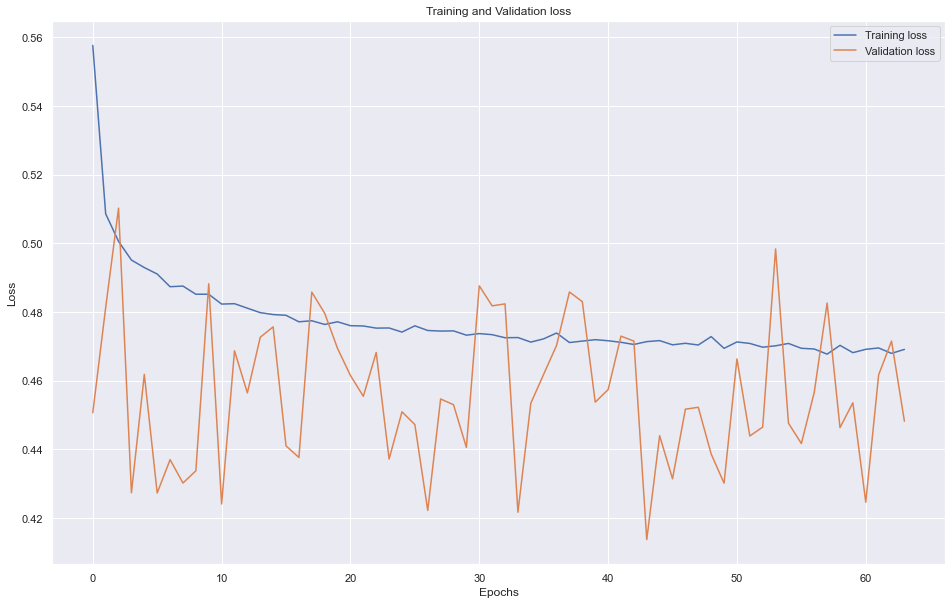

In [58]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

Plotting training and validation accuracy over epochs

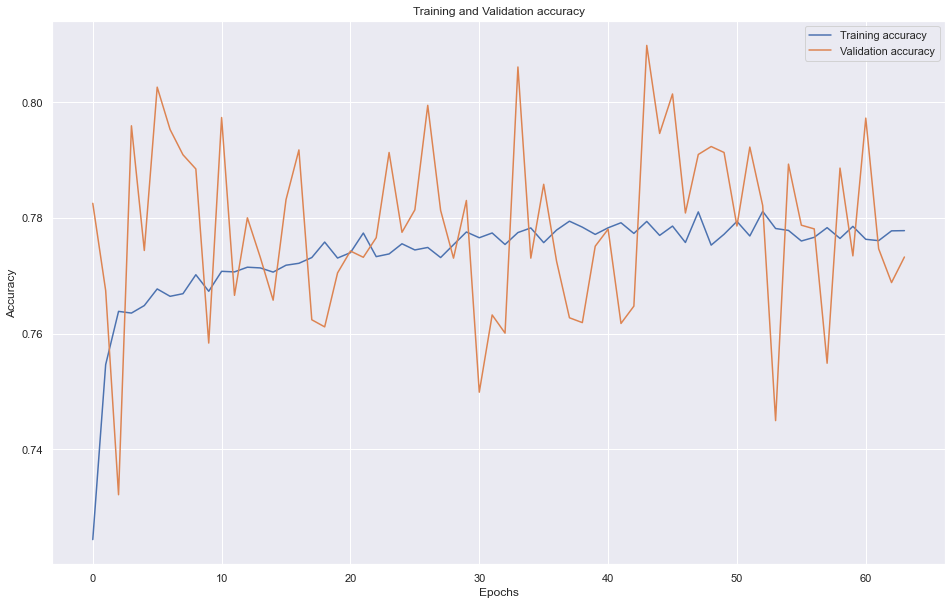

In [59]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
# Get the performance of the trained model on the training and test sets
y_train_pred = h_model.predict(X_train_scaled)
y_test_pred = h_model.predict(X_test_scaled)

1364/1364 [==============================] - 1s 564us/step


In [61]:
y_test_prediction = []
for i in y_test_pred:
    if i < 0.5:
        y_test_prediction.append(0)
    else:
        y_test_prediction.append(1)
y_test_prediction[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [62]:
for i in range(len(X_test_scaled)):
    print("Test Label: ", y_test.iloc[i])
    print("Confidence score: ", y_test_pred[i])#List of confidence for each class
    print("Prediction made by model: ", y_test_prediction[i]) #Choose the one with the highest confidence
    print("\n")

Test Label:  0
Confidence score:  [0.0655002]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09733996]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04141254]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21682824]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11304189]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4511927]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12978105]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34133425]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.58862185]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13016191]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5423104]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06044479]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01572076]
Prediction made by m

Test Label:  0
Confidence score:  [0.26520672]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20143369]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14360932]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.47724774]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00287377]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09754223]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8553606]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15124829]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25094226]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6001231]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14216898]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03297755]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.73189795]
Prediction made by 

Confidence score:  [0.38401723]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5562633]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54490596]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.45046452]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20085597]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0252417]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.06728356]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.65243]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20202707]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3967315]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0097225]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05444871]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15037805]
Prediction made by model:  0


Test Lab

Confidence score:  [0.11256145]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7082799]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.6840318]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00872471]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07759231]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04565403]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.48888528]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06334358]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05203918]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5346551]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06973699]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.82781744]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31509417]
Prediction made by model:  0


Test

Test Label:  0
Confidence score:  [0.01080388]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24850108]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3993277]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10307119]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18974122]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38836002]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11217938]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9480488]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4039007]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.73978347]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15438506]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.05472884]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17585535]
Prediction made by m

Confidence score:  [0.39158806]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3302307]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02721932]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.298638]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29890782]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1805683]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04765196]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34659252]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12668131]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.56251067]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6643969]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10391652]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11556929]
Prediction made by model:  0


Test L

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7829611]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5607358]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13600749]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5384888]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08512992]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9435249]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.68594605]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4436965]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5278235]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23207605]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0412544]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00466301]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.285

Test Label:  0
Confidence score:  [0.11209986]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05709182]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0440505]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.96513385]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9376787]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02927882]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35592642]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21384308]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.942657]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31010097]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30001417]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15435867]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01761365]
Prediction made by mo

Test Label:  0
Confidence score:  [0.07055146]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4309245]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09472279]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6388611]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0451662]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12428169]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3135715]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5243822]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09533563]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26430842]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3524979]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06302421]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02071171]
Prediction made by mode

Test Label:  0
Confidence score:  [0.74239844]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12068173]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1658378]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27810967]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27801064]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23744595]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.97025746]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.44957235]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.76061624]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02130024]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6543424]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.34301177]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12532844]
Prediction made by 

Test Label:  1
Confidence score:  [0.5859955]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8880988]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08003164]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9339094]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.47717738]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09304174]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.84538364]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31839556]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12419719]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9567699]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21815693]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6122706]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.32146072]
Prediction made by mod

Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8841911]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2078303]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.43827218]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18825181]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11045586]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60566914]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09379053]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01900846]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07039496]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44574916]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.871882]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01626201]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.



Test Label:  1
Confidence score:  [0.92591184]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.92351586]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.45734507]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15269302]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01546501]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42836815]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06382507]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09495772]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00794221]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.74709564]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17945245]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25743783]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03525016]
Prediction made

Test Label:  1
Confidence score:  [0.19300959]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.917692]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7150839]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00244464]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.32921416]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02233]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03555441]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.45880023]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23865736]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23477767]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6017764]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2668077]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.142189]
Prediction made by model:  

Confidence score:  [0.70324504]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.05977276]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7682388]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00679189]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09148257]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15596876]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6061757]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22105582]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5247993]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18157652]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00142103]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3424341]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9396704]
Prediction made by model:  1


Test L

Confidence score:  [0.04216024]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8639853]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01070751]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00858943]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40162683]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22149284]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4625392]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.800687]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5000939]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33885753]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05874532]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29354087]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13495585]
Prediction made by model:  0


Test L

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46570665]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.72614557]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2544711]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5377922]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10605976]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.813048]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7747308]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6634876]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.05287411]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1457495]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15387581]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8390241]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1187

Test Label:  0
Confidence score:  [0.80754185]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15752718]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22050816]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05178484]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.55147684]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.36282846]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30080417]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.51106817]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10836554]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.985757]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06309165]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.54585415]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5088938]
Prediction made by m

Confidence score:  [0.11217858]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.54417175]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0315447]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7872071]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8479353]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1425084]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9148011]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40807036]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3700298]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04637947]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08443785]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.36390218]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0757961]
Prediction made by model:  0


Test Lab

Confidence score:  [0.48582476]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32868135]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6367284]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33498186]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9114391]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7084708]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12353151]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0692585]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23055935]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.34525713]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00320144]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5684686]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3868784]
Prediction made by model:  0


Test La

Test Label:  1
Confidence score:  [0.8035489]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08931564]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0967302]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02626542]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22792296]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.41860545]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37342986]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.30253103]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3810783]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10648701]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09597646]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4838179]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.45752564]
Prediction made by mo

Test Label:  1
Confidence score:  [0.92132545]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07865066]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2803173]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8710374]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6809777]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7733281]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.54682046]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.27463222]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44916984]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13415505]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04055681]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5256457]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.52346253]
Prediction made by mod

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4446467]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08064895]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.59888566]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15139921]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.30232742]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18484676]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30012482]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7528513]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20661409]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21385401]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.14196986]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04476868]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Confidence score:  [0.91707975]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20802058]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39726034]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7952299]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13607371]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.68337655]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33017623]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.78795916]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.301122]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23749971]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24528484]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.50254434]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5407651]
Prediction made by model:  1


Test 

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.82149196]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9383328]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13928872]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06675784]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05038327]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5771919]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.44497532]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.50858134]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33492902]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6003652]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7494473]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14147025]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.2802571]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2909975]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7204443]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7220793]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8015464]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.95760167]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21617603]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17102632]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01044687]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19875725]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23922242]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9641468]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03187939]
Prediction made by model:  0


Test La

Confidence score:  [0.21122435]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10692157]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10019339]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1905824]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08505405]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.63440675]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16306181]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3810098]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37876]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8385155]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.65803766]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.27005592]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6683117]
Prediction made by model:  1


Test Lab

Test Label:  0
Confidence score:  [0.44454184]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25507468]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.76501155]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03223554]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31525654]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00567933]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03739581]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03626501]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09142794]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9000871]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5523061]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18276937]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40114754]
Prediction made by 

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.262828]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16808821]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10448473]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32253033]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.79664457]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5264918]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08541665]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.79720974]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.45311266]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29618204]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05336021]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2636829]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2836972]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1593068]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0502496]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25312966]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.54244685]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5401519]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.43937397]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0689374]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9702371]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.316948]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2645906]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.23863879]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42130

Confidence score:  [0.29471862]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2502932]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07760985]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06643315]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14087646]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46589696]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20816681]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05490664]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33542445]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00269644]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4531958]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.87997717]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.41246504]
Prediction made by model:  0


Tes

Test Label:  0
Confidence score:  [0.13688256]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12132446]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16758412]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7068926]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31157675]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31765625]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3889862]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.596615]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16606498]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2848531]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.43293086]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.41007096]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17330244]
Prediction made by mod

Confidence score:  [0.6613329]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06557309]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39279634]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04216589]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.75475574]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19681542]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25314274]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10163055]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.724673]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01031431]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46375105]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42806566]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6816379]
Prediction made by model:  1


Test 


Test Label:  0
Confidence score:  [0.12686977]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6131522]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19415754]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13861017]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89283335]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0370208]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36159775]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7853634]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24881248]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04499165]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26413572]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07880598]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1405941]
Prediction made by m

Test Label:  0
Confidence score:  [0.02014481]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3030466]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46471322]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9653885]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17708324]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.75475526]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.25742853]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4272274]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15457906]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26356375]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10542364]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.33365908]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2741299]
Prediction made by mo

Test Label:  0
Confidence score:  [0.0449739]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.44483528]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5931025]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19487795]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14753363]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3480161]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03570193]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.51604414]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22316778]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01589385]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2702044]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39869148]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30893463]
Prediction made by mo

Confidence score:  [0.5157194]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3776379]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22461401]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28209934]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19402593]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08267303]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26290253]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.68619955]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03236616]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.56733495]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5775902]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5996307]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07591314]
Prediction made by model:  0


Test 

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03898656]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.14891875]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24439217]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8133354]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03830691]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6886613]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0801417]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.48281297]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08619905]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.46993586]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7506595]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5059439]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2



Test Label:  1
Confidence score:  [0.8457836]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02588942]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2916338]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6167274]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8446514]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.138752]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20779571]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.43150747]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.48423892]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4078844]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23737366]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04132606]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21435484]
Prediction made by mod

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21998307]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01757017]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25892332]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02033125]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.58996576]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01856121]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9148708]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17319001]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.2746469]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7698128]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06574219]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6974039]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.25227153]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4650086]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5386838]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4335937]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03943796]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20959324]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8788838]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.61181635]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12372354]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.54230857]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.9646022]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.60523075]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5392537]
Prediction made by model:  1


Test La

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.27726486]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9667927]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5987133]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13035896]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37219557]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06156154]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24669614]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.82373416]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3393492]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7636247]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7953719]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16629145]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0

Confidence score:  [0.04499054]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13224915]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32339975]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06100854]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00566814]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.47155017]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9797389]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00327522]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89734924]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19499472]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02352161]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4349865]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16898994]
Prediction made by model:  0


Tes

Test Label:  1
Confidence score:  [0.63641506]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23246294]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01546181]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7654427]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.6565608]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.398904]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06866733]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10288195]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3786515]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23987016]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.83245295]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.76862746]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0635058]
Prediction made by mode

Prediction made by model:  1


Test Label:  1
Confidence score:  [0.69327974]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06227478]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2083251]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1226645]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09092002]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05952533]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.44480285]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3604058]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13934842]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11095843]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32910052]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04179172]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14013076]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33179736]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.92485785]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.239749]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3084538]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25659072]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8468502]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5232397]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.67891663]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.94573927]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0464334]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07322253]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.79

Confidence score:  [0.7820471]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31553924]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10193232]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1032223]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26866436]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02207632]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.55254376]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.56336284]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8413634]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07020532]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.54695255]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.76854765]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.41668686]
Prediction made by model:  0


Test

Confidence score:  [0.19100603]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21039948]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5905707]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09126665]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0382478]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30868882]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.47486472]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.45612887]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.94580495]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.56577647]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.44420502]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2233482]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14440727]
Prediction made by model:  0


Test

Confidence score:  [0.01946718]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3049134]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17114206]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3114784]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4172622]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36688387]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29182482]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0890172]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02497383]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.32354295]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7821368]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14576988]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.45700136]
Prediction made by model:  0


Test L

Confidence score:  [0.05121088]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11009365]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7739112]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07011178]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16519547]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17439528]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18012553]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31906733]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09910282]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26896694]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03233833]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38383684]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8376294]
Prediction made by model:  1


Tes

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00729863]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21639217]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13608849]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14682512]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.52860236]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.34331986]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7202254]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04425199]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.41685888]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13949786]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.510594]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.94456404]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0

Confidence score:  [0.03732619]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00265136]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7113697]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21514736]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00314937]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.90212303]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00826064]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07086284]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01740414]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06938249]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5301111]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03527305]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8500324]
Prediction made by model:  1


Test

Test Label:  0
Confidence score:  [0.2051894]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14964063]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10695741]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06751544]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2445433]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.98394376]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2371093]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.20530237]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39687458]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0466952]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4559289]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05251113]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09935749]
Prediction made by mod

Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9611828]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5588188]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54465485]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.25282043]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9398837]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17825931]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09173363]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5944186]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.54256636]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.74944013]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09968533]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29347938]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14380662]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.71417916]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.62416065]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.33625364]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15239497]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44575033]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10770215]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8727518]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.74087095]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08149978]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1507035]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5241499]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0

Confidence score:  [0.6164295]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.8409528]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15017796]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33040068]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.71886486]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04959845]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02255036]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39286938]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.55424]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.32904187]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35381642]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5048184]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08346953]
Prediction made by model:  0


Test La

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21974905]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05491874]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.43319377]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.617918]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01995841]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.510139]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09322517]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.52102864]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5326855]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20893635]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01770607]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4364249]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3458885]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.51953566]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17962782]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6995585]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54032075]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.66124344]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.26177615]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21598478]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8655923]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07259693]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.32006115]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05253292]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04806857]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.66471887]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5646992]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23987153]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.97146714]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24377532]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11093242]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12478247]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00820142]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.68687457]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1506932]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38221484]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Confidence score:  [0.38740322]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19830593]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.45458212]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05446574]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5821165]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22779079]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6378328]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46803626]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17264536]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.56367]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5100468]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.68354094]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13490601]
Prediction made by model:  0


Test La

Confidence score:  [0.5839823]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.16698799]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1460688]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01258909]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31491572]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03390792]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01445062]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7137524]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18657495]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1965794]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28479984]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2654721]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19573973]
Prediction made by model:  0


Test L

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21925397]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8269]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.39395198]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17330106]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01901398]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19288704]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16561556]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42248031]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07460766]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6465288]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0234042]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02043393]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.76

Confidence score:  [0.10821143]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.63697445]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20008183]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.71464163]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5571254]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07489187]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.46808735]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6242231]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1203679]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03164119]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6675518]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13316646]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.93974966]
Prediction made by model:  1


Test 

Confidence score:  [0.39827785]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02487081]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.40232357]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29207328]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.799876]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5699282]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.34650436]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3426595]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06970979]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.97043777]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00486179]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08426479]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.57299614]
Prediction made by model:  1


Test 

Test Label:  0
Confidence score:  [0.19965933]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05787027]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.63749665]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04444391]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0357236]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.22677863]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.76687866]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04190384]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.316509]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6260934]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3306848]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4649394]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4332532]
Prediction made by model

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13166621]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42721602]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.58737993]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21517417]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.75434756]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5083754]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23627108]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37428257]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10398255]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.88528186]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.49775025]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29926968]
Prediction made by model:  0


Test Label:  0
Confidence score:  

Confidence score:  [0.74051744]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5107159]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0877353]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8107304]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40872064]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.74909186]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24563769]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05004778]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17985368]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.67150164]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02282551]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40357852]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06724819]
Prediction made by model:  0


Test

Confidence score:  [0.5315748]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21283327]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01919543]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.55562997]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.11341663]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02932862]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.77386916]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.15011372]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00781868]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22108126]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06332733]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.47665152]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07770931]
Prediction made by model:  0


Te

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1507481]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10629921]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24148473]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40509042]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16557322]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01847254]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09726633]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4878716]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.40096977]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05914633]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9500268]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08666894]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8981687]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.56963265]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09141336]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32562143]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4360908]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19479626]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.93742794]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5786032]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.47882375]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24604486]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04456821]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26616856]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.43687984]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1404364]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2989792]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7180212]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.52912605]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10702337]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21393938]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21851745]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19422548]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18533033]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.13026062]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.19789076]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9421338]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5077871]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.13824971]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6874866]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.3417778]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2128967]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22995867]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2724221]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.50950396]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.540485]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.48548934]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8492761]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.26023

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8511273]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19294344]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31649697]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01136437]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33182508]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.90278864]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.66970193]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.49326736]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42472818]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.66359127]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.25475416]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4077721]
Prediction made by model:  0


Test Label:  1
Confidence score:  [

Confidence score:  [0.2854888]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23478721]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27135745]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5657255]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.76147926]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.05961228]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13553615]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.541146]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06422506]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05307174]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31671482]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30389038]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.21163821]
Prediction made by model:  0


Test 

Confidence score:  [0.48027554]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5205145]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02280727]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01521425]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18521374]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.2684819]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36338633]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0200906]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23388843]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17929332]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06658014]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6944112]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5965135]
Prediction made by model:  1


Test L

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.65012705]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21064016]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89812946]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06585374]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.69159865]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16568112]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1886529]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09282418]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0685688]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36227438]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34900275]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07065705]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7570533]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04398261]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14959201]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03999771]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.44114444]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37981537]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02792596]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.81989264]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5124126]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.32870442]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.42751366]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7723539]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0

Confidence score:  [0.48661605]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9407084]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.11386304]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01186441]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.39093313]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10021469]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15437366]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5128042]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46493733]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39536586]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3288536]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11988617]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.2820229]
Prediction made by model:  0


Test 

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1783889]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9541376]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.41296208]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18195027]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20936497]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8864038]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.38352725]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.66940933]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16459572]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5843375]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5698562]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.91016656]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9

Confidence score:  [0.09951288]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0120055]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19533478]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32422236]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0913807]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7289728]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.05411213]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46859002]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04253279]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09210192]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5745163]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04771987]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09239198]
Prediction made by model:  0


Test 

Confidence score:  [0.8965737]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2311706]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10731186]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.63730353]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.47801882]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36215886]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5948915]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.70132315]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23789115]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60349125]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14421909]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9307566]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24096563]
Prediction made by model:  0


Test 

Confidence score:  [0.32291976]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7988477]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5109209]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04901005]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23014222]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07646355]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7673836]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10875504]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07577834]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3736114]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1686589]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34111533]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29767776]
Prediction made by model:  0


Test L

Confidence score:  [0.43595895]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29973364]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5576457]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2440798]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11322365]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.598743]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.13063326]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35903642]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.81678885]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6241715]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.07661035]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.82062197]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22020036]
Prediction made by model:  0


Test L

Test Label:  1
Confidence score:  [0.85654277]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.75781006]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00606484]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19037962]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11144189]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40761507]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.63418907]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08508633]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3193283]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.535033]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.53635854]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20778179]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2947575]
Prediction made by mo

Confidence score:  [0.03754882]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06151104]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08583699]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3226862]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29095152]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8946351]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.317905]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1656151]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11866497]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29943705]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4849108]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06089089]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03579183]
Prediction made by model:  0


Test La

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.68418086]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8223582]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02099835]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.69043046]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12491585]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12807962]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14669563]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05761824]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04906381]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3061358]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16972472]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7640385]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7054029]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06603841]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7672007]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.251623]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11736231]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2814651]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.77459556]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6438921]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21350412]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29871246]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5082061]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.32828015]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.134

Confidence score:  [0.6966066]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.34693688]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19015896]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5390238]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2928565]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01532018]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.48873636]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60822695]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5731985]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06079608]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.85365933]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06945568]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24014865]
Prediction made by model:  0


Test 

Confidence score:  [0.10966562]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.58169913]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09333984]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05828]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5894255]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.37918836]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08371441]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32962063]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0164649]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10488009]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19803162]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22632487]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12430533]
Prediction made by model:  0


Test L

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7199423]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.3198384]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9303791]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33502072]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13729097]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2043139]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46819162]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.71029615]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08463237]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8326664]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.37264714]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07118528]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5

Test Label:  0
Confidence score:  [0.22775215]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19242534]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5286981]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01823548]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33102298]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15319091]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.88649654]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04560421]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7992441]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02275487]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.49734765]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0853994]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06336235]
Prediction made by m

Confidence score:  [0.02620247]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3047124]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.317683]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20238476]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3768046]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27707645]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02230158]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42272624]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2825683]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3529455]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.25156596]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02636061]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.86957073]
Prediction made by model:  1


Test La

Confidence score:  [0.12385381]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25686893]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6218388]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2393352]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18827054]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28808236]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13721772]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32561386]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33354914]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05561191]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00535879]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.9066001]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.62197965]
Prediction made by model:  1


Test

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08108432]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1256404]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36288145]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.40459406]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21053678]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24099374]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.48688117]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.49379954]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02304869]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24913469]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8047867]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9135257]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0

Confidence score:  [0.20539828]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.27249402]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0157927]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02032123]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1828649]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03568946]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.75677675]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.35236347]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30200547]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20722845]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89998966]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.918684]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.81729627]
Prediction made by model:  1


Test 

Test Label:  0
Confidence score:  [0.67539895]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9563337]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12684467]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.85690486]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.607337]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18095522]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25648987]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2803284]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8215817]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.4879077]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11712141]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28814924]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.26826882]
Prediction made by mode

Test Label:  0
Confidence score:  [0.36578116]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14687972]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02695788]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8792989]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5705355]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2415067]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33040512]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30874687]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0049458]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.49930063]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4690739]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02112583]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31767598]
Prediction made by mod

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60658795]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09560233]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5257673]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22454208]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5533736]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06330548]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15871984]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08626836]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08808768]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20013349]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2581523]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31248638]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4796261]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2682124]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.295391]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03015054]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.71504515]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.323832]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.775367]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9003819]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06864838]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02146252]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15276162]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06313771]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.95167

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8027263]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.4055725]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1936799]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.67144907]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5682152]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09904953]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13290977]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.68777716]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9039486]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.73823214]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4920153]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13395883]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.54

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00425844]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32114547]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00510662]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.812169]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.7197404]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.65042555]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01696148]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.64606833]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.6886304]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10766863]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.73728245]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16919623]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.20906222]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23988062]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22707742]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.025746]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6056158]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02439685]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04393092]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14305067]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.832843]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.7945159]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.2668097]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.50462884]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40583447]
Prediction made by model:  0


Test Lab

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22152412]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40375903]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9207389]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.97651684]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8776452]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46630514]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.40131375]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5967084]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.43657142]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.59299034]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.41495487]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06733301]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.48727006]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18205431]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4899293]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23225294]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27823293]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23531939]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3016932]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15689832]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.96343964]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.63970965]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.8719628]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03250081]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0

Test Label:  0
Confidence score:  [0.05935373]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6439507]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24225032]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23741013]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05162684]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14193597]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31669518]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.69063103]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.45526096]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.090594]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01589087]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5190342]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0415848]
Prediction made by mod

Confidence score:  [0.03546707]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.33346823]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31372884]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26411232]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38247856]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.56012034]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04879245]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30139142]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36633787]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28469652]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07413537]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7237495]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.60832775]
Prediction made by model:  1


Te

Confidence score:  [0.5316336]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09360105]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8850164]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.84532005]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40771407]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.342501]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.27829933]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7562998]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4466723]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46737242]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.74885595]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.87180495]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.35078105]
Prediction made by model:  0


Test La

Test Label:  0
Confidence score:  [0.76487]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.154954]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.58851886]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.232163]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.581782]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46036458]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.89252347]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06016076]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17477074]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.83743906]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8764113]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.6690892]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1494138]
Prediction made by model:  0


Confidence score:  [0.22427437]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01586042]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4207072]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.67770255]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.45377722]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6304917]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04272262]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17027879]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25732726]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02380995]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7302984]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.7707022]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.11241981]
Prediction made by model:  0


Test 

Confidence score:  [0.16857676]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6171682]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5243594]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16912693]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12110235]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4181821]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.50829303]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.69865733]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.28593558]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5692066]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19616386]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91991633]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.53718907]
Prediction made by model:  1


Test 

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.59260744]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10064166]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01797235]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.75164783]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8303179]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.25121358]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.626833]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03252646]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.22700733]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91006637]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21975684]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0369903]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.5486025]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04640298]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09484171]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31898698]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6250716]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.90637815]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18852931]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.58018947]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17169647]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01705199]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32142904]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20728557]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03148396]
Prediction made by model:  0


Tes

Confidence score:  [0.18926024]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10383657]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.14957826]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1160045]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24391522]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7555027]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.97516716]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.70274407]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17198616]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23213401]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11106645]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.52546394]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.23298982]
Prediction made by model:  0


Tes

Test Label:  1
Confidence score:  [0.58794075]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02424365]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.56680024]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.26833084]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19815136]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02769534]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01513493]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6040624]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.63450044]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.01920772]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04529307]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.84413546]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.8194759]
Prediction made by 

Confidence score:  [0.06979065]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4956837]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.19471554]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.49611726]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.2940775]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26573747]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34212083]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10580833]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.67500806]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.80214995]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6854804]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04576486]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12023703]
Prediction made by model:  0


Test

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05323901]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2111182]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09722516]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.73414224]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17495982]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9014623]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5593929]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14708704]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22905256]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3200621]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2721813]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01241577]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03888332]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8458626]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.53405386]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.34541547]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0785154]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37795997]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2146373]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23403408]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.9083208]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.05493142]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03047556]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.63146406]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31836233]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7077962]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22895941]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07359944]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21050942]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08055163]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.570993]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2593236]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07178072]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02507088]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8154719]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06941553]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6

Confidence score:  [0.46868837]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02459981]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8318265]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.78036004]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24766482]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05771045]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13091163]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01534598]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.49195427]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35390046]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.76171213]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40781128]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14457315]
Prediction made by model:  0


Te

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12782983]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.45887893]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7552216]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46141648]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7084932]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4985832]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11710864]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5389464]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15207107]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.24976045]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.83345705]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.71875006]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.1718868]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29235753]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.80868125]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23359326]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6701015]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.61689454]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.58448255]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.27945244]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04958431]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.527126]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03638544]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27444187]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02103812]
Prediction made by model:  0


Test 

Confidence score:  [0.5746854]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.33816263]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2863471]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40099242]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02251898]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7595806]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.365749]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8214625]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.71922755]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2810931]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25260338]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33375788]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03289626]
Prediction made by model:  0


Test Lab

Confidence score:  [0.3684469]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26965076]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16929632]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89403486]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01176249]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.84685665]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.74555457]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.4816543]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07236546]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01999458]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.2318502]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22703287]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25198895]
Prediction made by model:  0


Test

Test Label:  1
Confidence score:  [0.8123117]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9634928]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06229927]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0153196]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.470625]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11630473]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.68461436]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5389647]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.46999675]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6087116]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.23943956]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9441599]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10754761]
Prediction made by model:

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10275799]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.42459956]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3678805]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2566203]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.79763216]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6690074]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19578497]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.64561456]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3893418]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.41472724]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14111303]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91873366]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.73342735]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15798397]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0529118]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09382022]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3608799]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3601625]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7621786]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.68069685]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04533075]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13444315]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6274652]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2684633]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3057491]
Prediction made by model:  0


Test Lab

Test Label:  0
Confidence score:  [0.03436365]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44444796]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30254564]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5162249]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17787796]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06268331]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8594609]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.58413476]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.48463976]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30797496]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04952126]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13311383]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02577302]
Prediction made by 

Test Label:  0
Confidence score:  [0.1222625]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09852254]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.39473733]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04092564]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.47431707]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44387624]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12235393]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0728281]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7646081]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.82888377]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.8123692]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.3029659]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1165977]
Prediction made by mode

Confidence score:  [0.2850351]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3612718]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07661501]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11550939]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12702553]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6650151]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17738627]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7305839]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.26819098]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.92471987]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0086359]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.09548002]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.73899513]
Prediction made by model:  1


Test L

Confidence score:  [0.23978439]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.64184165]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.89274985]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01171177]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06849514]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21985303]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.08490726]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34563905]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6376831]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00346325]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.49080867]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06815717]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5547089]
Prediction made by model:  1


Tes

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24107951]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07173304]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35361865]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4163657]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6779698]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06406177]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.85217065]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03897802]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16527413]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05902067]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.81292975]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01190018]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Confidence score:  [0.89795303]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.47011858]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.74029624]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.6711944]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46833423]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16518916]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.51873004]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.69890356]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5956815]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.50236607]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.9853253]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18081264]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03942464]
Prediction made by model:  0


Test

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07232154]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22411731]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00362332]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10400334]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3050574]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18737186]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.35620403]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00991041]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8184162]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.82089156]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.46308506]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22105789]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2611211]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8736363]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.18595856]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2982748]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91151005]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01410345]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.38476047]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18372916]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02245431]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08619729]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46082613]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9046688]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11308846]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02427864]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6251879]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5979952]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.03043651]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1019219]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3454441]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5230519]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.267849]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46962678]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91724867]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01522899]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.087

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.30224898]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7047749]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5512653]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7202376]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01707177]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.40735906]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.43666855]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.36013147]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2208467]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13794577]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11027729]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9619172]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5

Confidence score:  [0.02317557]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.7539723]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02404411]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26684058]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.23611581]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02117509]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3919586]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5486684]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.117433]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.283527]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0225857]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.48191756]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05004749]
Prediction made by model:  0


Test Labe

Test Label:  0
Confidence score:  [0.09991167]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3012422]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2060653]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44027033]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04235587]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5688082]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09734938]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.287439]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16133282]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19958295]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44661477]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.93075705]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.67002547]
Prediction made by mod

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08842939]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13450326]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03039433]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05813395]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03057256]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9435471]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.24315353]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11800994]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.19140975]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28518468]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.48770022]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.23753868]
Prediction made by model:  0


Test Label:  0
Confidence score:  

Confidence score:  [0.3083076]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8469003]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1627722]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15277205]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00352286]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.80345994]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19857328]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37236983]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.43001235]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08158924]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5687062]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09025373]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60981256]
Prediction made by model:  1


Test 

Test Label:  0
Confidence score:  [0.16327187]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.3710541]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.14272471]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2556613]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6520888]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.29122657]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10254669]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8652568]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.39507475]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.16424441]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5682272]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24795383]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.75939935]
Prediction made by mod

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.13666527]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.89593554]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.11119583]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.77820337]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.43550888]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.49853715]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46640548]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.90464395]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6066641]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.04727665]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9056729]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01466063]
Prediction made by model:  0


Test Label:  0
Confidence score:  [

Test Label:  1
Confidence score:  [0.3218357]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18461056]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27140477]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.90415335]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00907957]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01389068]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5219593]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01277936]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.51070315]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10993305]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21325798]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8460055]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.06358165]
Prediction made by m

Prediction made by model:  0


Test Label:  1
Confidence score:  [0.68588924]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.02706549]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25346592]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22633792]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11993168]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06015586]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13618296]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9874129]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.88911754]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54436153]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14819047]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03225955]
Prediction made by model:  0


Test Label:  1
Confidence score:  

Confidence score:  [0.89832604]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.37525544]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22646834]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.33849674]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0537537]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.26824147]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24083336]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11479179]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1003437]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0693824]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18649068]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.53372973]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.40827623]
Prediction made by model:  0


Test

Confidence score:  [0.06533997]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10383796]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.15563354]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11874032]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.07452277]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.12337066]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02004162]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4705232]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00366834]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21036792]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00426871]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.1859431]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9226704]
Prediction made by model:  1


Test

Confidence score:  [0.13151345]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.5111623]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7163122]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08783219]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01884597]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3388246]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7838916]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.26913637]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.04339765]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.75508004]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.4710912]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.72540504]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00617082]
Prediction made by model:  0


Test L

Confidence score:  [0.6565643]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6142597]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.01168795]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25046095]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6254342]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.8554627]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.0194705]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32867548]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2611098]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.60277516]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.39324966]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7924276]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.41565496]
Prediction made by model:  0


Test Lab

Test Label:  0
Confidence score:  [0.2100299]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46804726]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.43666118]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.34767717]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08466333]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03211272]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.37614924]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.66985214]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6158272]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.30530238]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.80114937]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.15239273]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6085367]
Prediction made by m

Confidence score:  [0.01515042]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.78586257]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.87079865]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10489479]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.41758493]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.44547832]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11876922]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.3041087]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6512464]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.76457775]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10128595]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8635009]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.16370907]
Prediction made by model:  0


Test

Confidence score:  [0.23910189]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.57597274]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.27586177]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.62614304]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7948053]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6752055]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.20900609]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.91046184]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14257479]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.6542451]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14256212]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11795448]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02547313]
Prediction made by model:  0


Test

Confidence score:  [0.24958734]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00318467]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.8175459]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10609899]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5932581]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.09697361]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5320056]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.6307826]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7110433]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.96787965]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.93507326]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.08528595]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.9198293]
Prediction made by model:  1


Test La

Prediction made by model:  1


Test Label:  0
Confidence score:  [0.1187153]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03031259]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38318646]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06065738]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.373017]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.06354125]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.39360714]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5016319]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.03836763]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.4333453]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22903879]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5059767]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.86

Prediction made by model:  1


Test Label:  1
Confidence score:  [0.31748667]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.08736304]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39537802]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.93044525]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.7562698]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.17173585]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.299424]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.24782339]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.5874986]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22993322]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.17988203]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.21943589]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.67423373]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.677056]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.25353113]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.80854636]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.548875]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.00731467]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00757516]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11558751]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2091782]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.30459607]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01449602]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.18502073]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7102278]
Prediction made by model:  1


Test La

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.13296907]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.84599435]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.30970684]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.43548772]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.00437396]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.74106836]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.10526659]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.29237318]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.27456537]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.10943072]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01020923]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.4140067]
Prediction made by model:  0


Test Label:  0
Confidence score:  

Confidence score:  [0.3664399]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.8877734]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21680105]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29623792]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.93893194]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.45032302]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7033763]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.12707569]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.134598]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.47046036]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7100752]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.57742506]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.21943037]
Prediction made by model:  0


Test La

Prediction made by model:  0


Test Label:  0
Confidence score:  [0.29944125]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.60173655]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.3097045]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22242314]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.1806154]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46105564]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7192776]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54344386]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.4385412]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.25278625]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.05484947]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.01136433]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.

Confidence score:  [0.80652666]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.66514426]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.2694412]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.2392085]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.20826386]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.39326593]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02828624]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11114764]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.70837945]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.22750781]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.31525052]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.02522966]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11685637]
Prediction made by model:  0


Tes



Test Label:  0
Confidence score:  [0.91309]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.49236223]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.61697423]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.24181795]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.46149647]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.6604576]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.54802877]
Prediction made by model:  1


Test Label:  1
Confidence score:  [0.5746058]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.5734773]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.14499286]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.32508105]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.08772309]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.38007012]
Prediction made by mo

Confidence score:  [0.07864264]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11462488]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.53538203]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.31754652]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.11931224]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0553406]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.0637195]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.28332055]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.46112323]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.22610395]
Prediction made by model:  0


Test Label:  1
Confidence score:  [0.7297543]
Prediction made by model:  1


Test Label:  0
Confidence score:  [0.19334112]
Prediction made by model:  0


Test Label:  0
Confidence score:  [0.03977682]
Prediction made by model:  0


Test

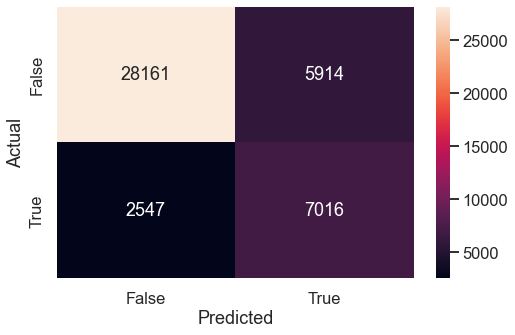

In [64]:
plt.figure(figsize=(8,5))

cm_ANN_clf = confusion_matrix(y_test, y_test_prediction)

sns.set_context('talk')
ax = sns.heatmap(cm_ANN_clf, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [65]:
clfRep = classification_report(y_test, y_test_prediction)
print(clfRep)

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     34075
           1       0.54      0.73      0.62      9563

    accuracy                           0.81     43638
   macro avg       0.73      0.78      0.75     43638
weighted avg       0.84      0.81      0.82     43638



In [66]:
y_test_pred_ANN = h_model.predict(X_test_scaled).ravel()
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_test, y_test_pred_ANN)
auc_ANN = auc(fpr_ANN, tpr_ANN)

1364/1364 [==============================] - 1s 576us/step


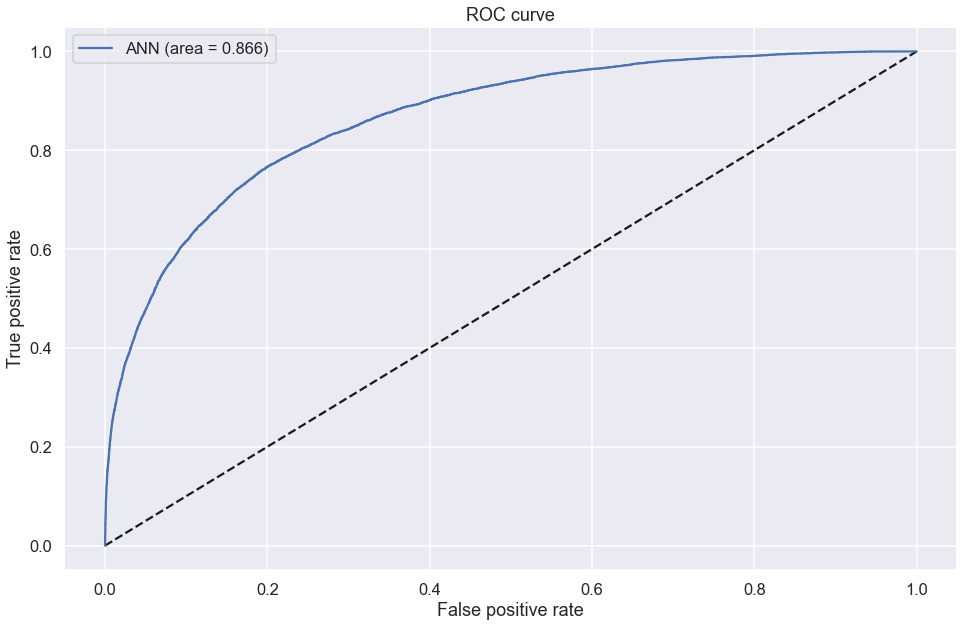

In [67]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ANN, tpr_ANN, label='ANN (area = {:.3f})'.format(auc_ANN))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [68]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_ANN)

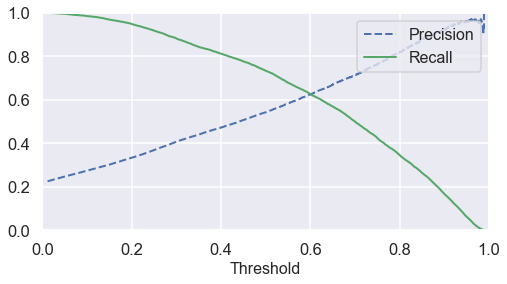

In [69]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

### DecisionTree (Undersampling, Balanced) <a id="part11.2"></a>

In [75]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)

dt_clf = DecisionTreeClassifier(class_weight='balanced', max_depth = 7, max_features = 7, ccp_alpha=0.001, random_state=0)

In [76]:
steps = [('under', undersampler), ('clf', dt_clf)]
gr_dt_clf = Pipeline(steps=steps)

In [77]:
gr_dt_clf.fit(X_train_scaled, y_train)

y_train_pred = gr_dt_clf.predict(X_train_scaled)
y_test_pred = gr_dt_clf.predict(X_test_scaled)

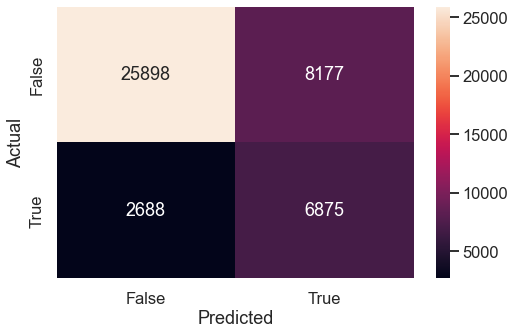

In [78]:
plt.figure(figsize=(8,5))

# Take a look at the confusion matrix on the test set prediction results
cm_gr_dt_clf = confusion_matrix(y_test, y_test_pred)

sns.set_context('talk')
ax = sns.heatmap(cm_gr_dt_clf, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [79]:
clfRep_gr_dt_clf = classification_report(y_test, y_test_pred)
print(clfRep_gr_dt_clf)

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     34075
           1       0.46      0.72      0.56      9563

    accuracy                           0.75     43638
   macro avg       0.68      0.74      0.69     43638
weighted avg       0.81      0.75      0.77     43638



In [80]:
print(gr_dt_clf.predict(X_test_scaled.iloc[[1]]))
print(y_test.iloc[1])
print(gr_dt_clf.predict(X_test_scaled.iloc[[42]]))
print(y_test.iloc[42])

[0]
0
[1]
1


In [81]:
y_test_pred_DT = gr_dt_clf.predict_proba(X_test_scaled)[:, 1]
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test, y_test_pred_DT)
auc_DT = auc(fpr_DT, tpr_DT)

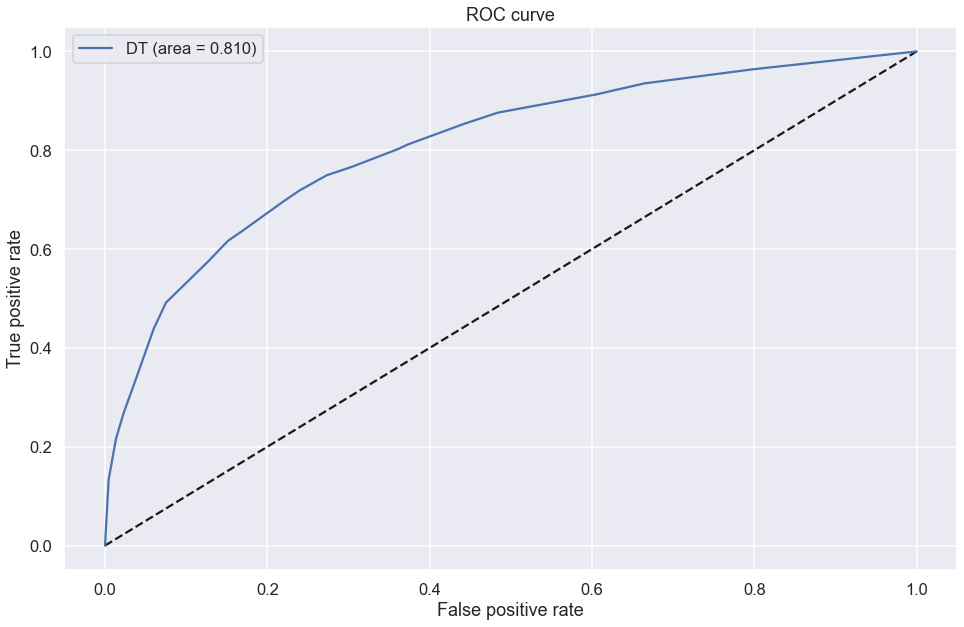

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_DT, tpr_DT, label='DT (area = {:.3f})'.format(auc_DT))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [83]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_DT)

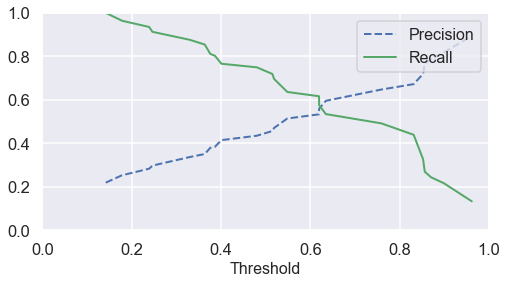

In [84]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

### SupportVectorMachine (SVC) (Undersampling)<a id="part11.3"></a>

In [85]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)

svc_clf = svm.SVC(probability=True, random_state=0)

In [86]:
# declare a pipeline that consists of the undersampler and the classifier
steps = [('under', undersampler), ('clf', svc_clf)]
gr_svc_clf = Pipeline(steps=steps)

In [87]:
gr_svc_clf.fit(X_train_scaled, y_train)

# The error on the training and test data sets
y_train_pred = gr_svc_clf.predict(X_train_scaled)
y_test_pred = gr_svc_clf.predict(X_test_scaled)

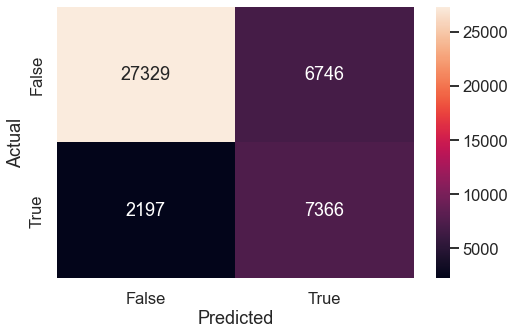

In [88]:
plt.figure(figsize=(8,5))

# Take a look at the confusion matrix on the test set prediction results
cm_gr_svc_clf = confusion_matrix(y_test, y_test_pred)

sns.set_context('talk')
ax = sns.heatmap(cm_gr_svc_clf, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [89]:
clfRep_gr_svc_clf = classification_report(y_test, y_test_pred)
print(clfRep_gr_svc_clf)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     34075
           1       0.52      0.77      0.62      9563

    accuracy                           0.80     43638
   macro avg       0.72      0.79      0.74     43638
weighted avg       0.84      0.80      0.81     43638



In [90]:
print(gr_svc_clf.predict(X_test_scaled.iloc[[1]]))
print(y_test.iloc[1])
print(gr_svc_clf.predict(X_test_scaled.iloc[[42]]))
print(y_test.iloc[42])

[0]
0
[1]
1


In [91]:
y_test_pred_SVC = gr_svc_clf.predict_proba(X_test_scaled)[:, 1]
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(y_test, y_test_pred_SVC)
auc_SVC = auc(fpr_SVC, tpr_SVC)

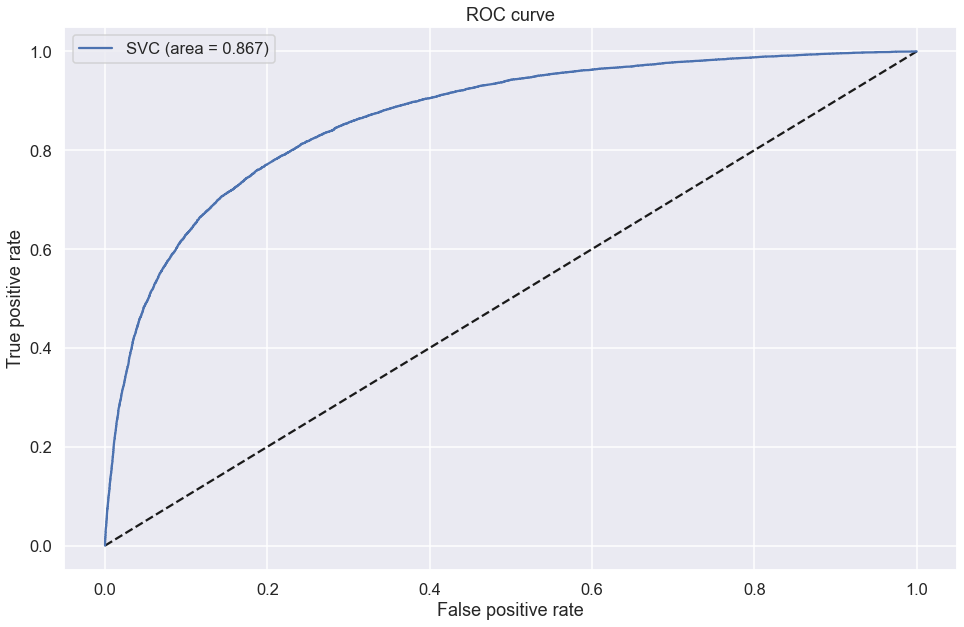

In [92]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_SVC, tpr_SVC, label='SVC (area = {:.3f})'.format(auc_SVC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [93]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_SVC)

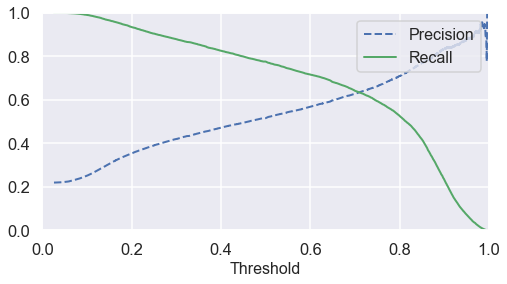

In [94]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

### RandomForest (Undersampling) <a id="part11.4"></a>

In [95]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)

rf_clf = RandomForestClassifier(random_state=0)

In [96]:
# declare a pipeline that consists of the undersampler and the classifier
steps = [('under', undersampler), ('clf', rf_clf)]
gr_rf_clf = Pipeline(steps=steps)

In [97]:
gr_rf_clf.fit(X_train_scaled, y_train)

# The error on the training and test data sets
y_train_pred = gr_rf_clf.predict(X_train_scaled)
y_test_pred = gr_rf_clf.predict(X_test_scaled)

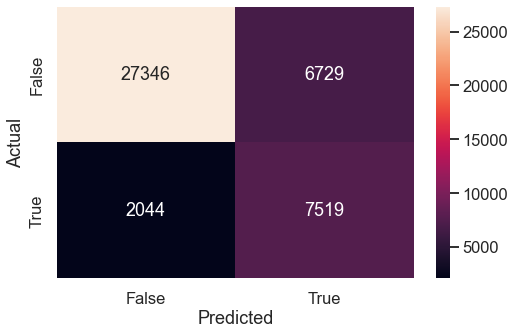

In [98]:
plt.figure(figsize=(8,5))

# Take a look at the confusion matrix on the test set prediction results
cm_gr_rf_clf = confusion_matrix(y_test, y_test_pred)

sns.set_context('talk')
ax = sns.heatmap(cm_gr_rf_clf, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [99]:
clfRep_gr_rf_clf = classification_report(y_test, y_test_pred)
print(clfRep_gr_rf_clf)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     34075
           1       0.53      0.79      0.63      9563

    accuracy                           0.80     43638
   macro avg       0.73      0.79      0.75     43638
weighted avg       0.84      0.80      0.81     43638



In [100]:
print(gr_rf_clf.predict(X_test_scaled.iloc[[1]]))
print(y_test.iloc[1])
print(gr_rf_clf.predict(X_test_scaled.iloc[[42]]))
print(y_test.iloc[42])

[0]
0
[1]
1


In [101]:
y_test_pred_RF = gr_rf_clf.predict_proba(X_test_scaled)[:, 1]
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_test_pred_RF)
auc_RF = auc(fpr_RF, tpr_RF)

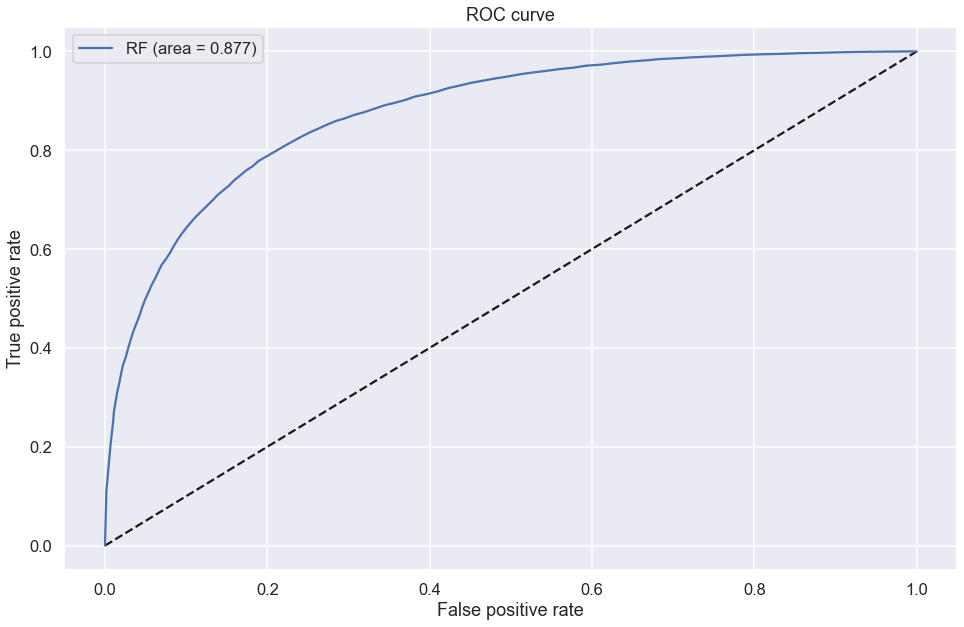

In [102]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_RF, tpr_RF, label='RF (area = {:.3f})'.format(auc_RF))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [103]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_RF)

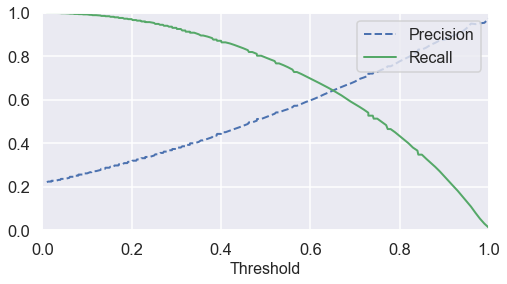

In [104]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

## Combining all classifier results <a id="part11.5"></a>

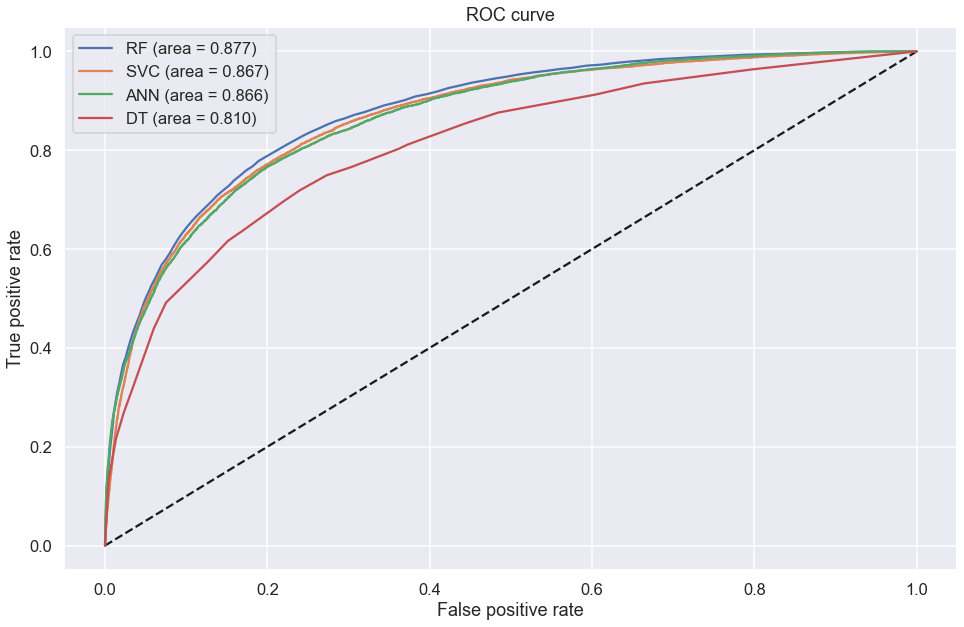

In [105]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_RF, tpr_RF, label='RF (area = {:.3f})'.format(auc_RF))
plt.plot(fpr_SVC, tpr_SVC, label='SVC (area = {:.3f})'.format(auc_SVC))
plt.plot(fpr_ANN, tpr_ANN, label='ANN (area = {:.3f})'.format(auc_ANN))
plt.plot(fpr_DT, tpr_DT, label='DT (area = {:.3f})'.format(auc_DT))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Confusion Matrix (All models) <a id="part11.6"></a>

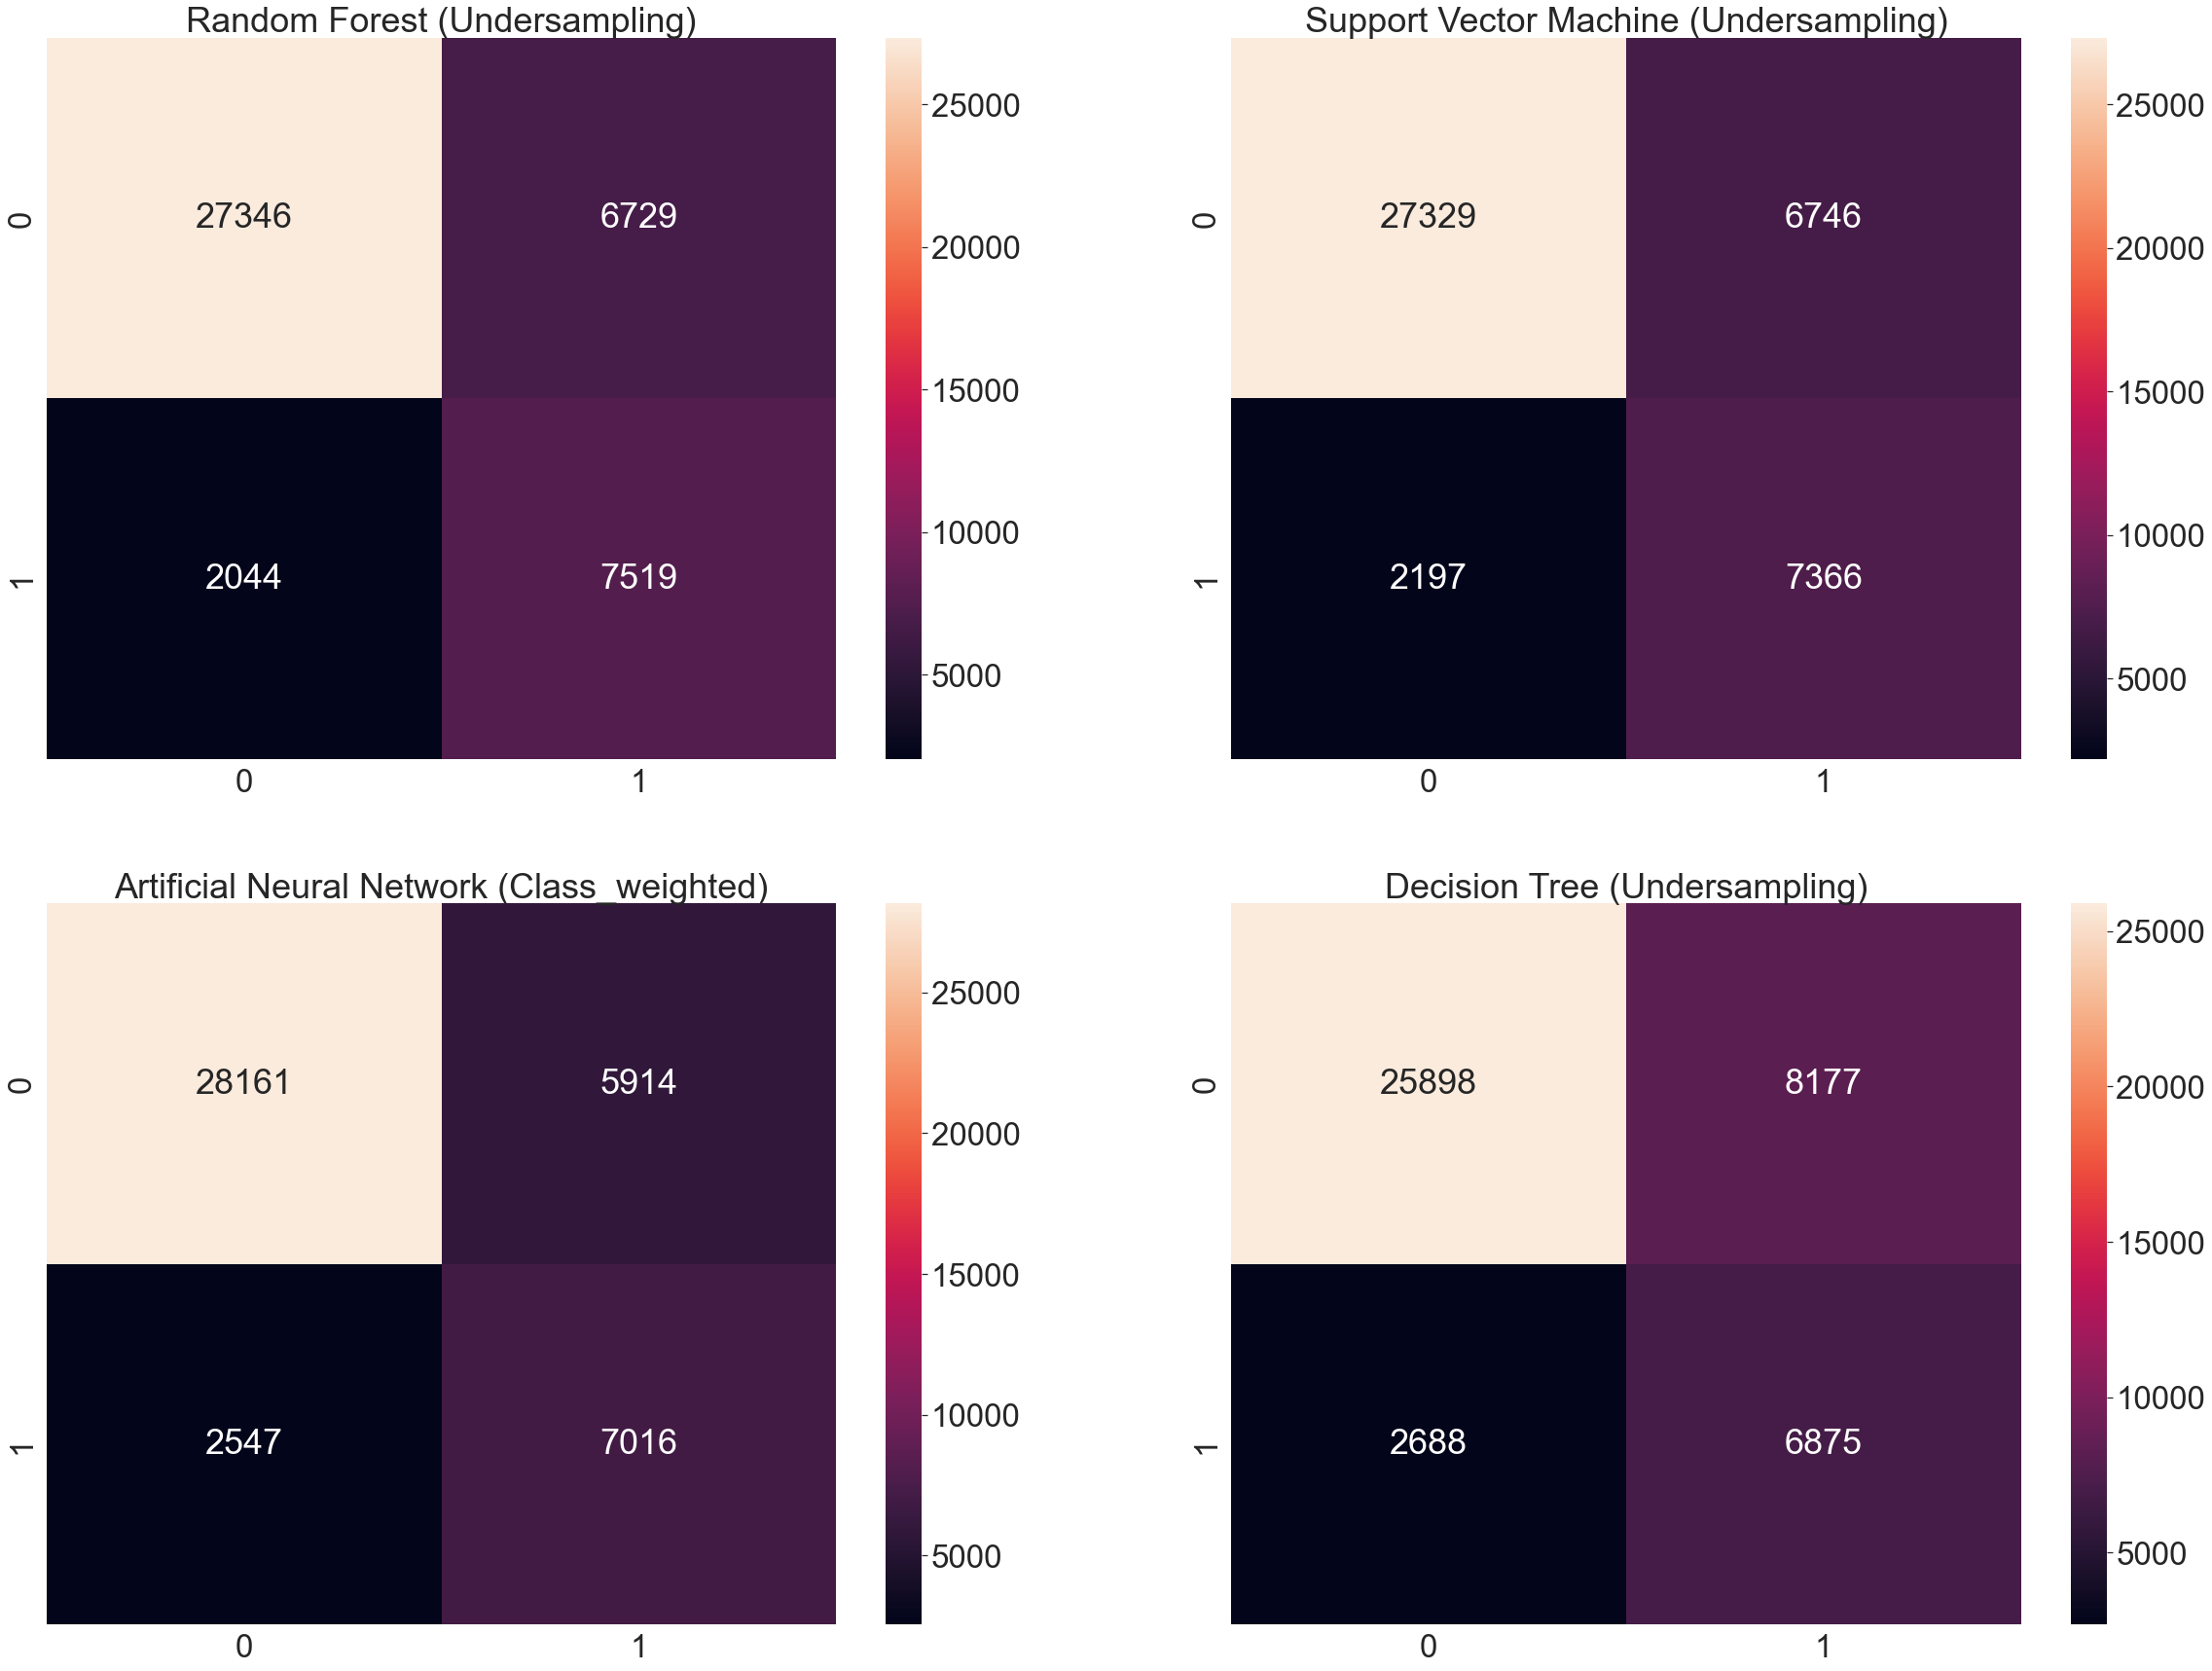

In [106]:
sns.set(font_scale = 3)
fig = plt.figure(figsize=(40,30))
ax1 = fig.add_subplot(2, 2, 1) 
ax1.set_title('Random Forest (Undersampling)')
ax2 = fig.add_subplot(2, 2, 2) 
ax2.set_title('Support Vector Machine (Undersampling)')
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Artificial Neural Network (Class_weighted)')
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Decision Tree (Undersampling)')
sns.heatmap(data=cm_gr_rf_clf, annot=True, fmt='d', ax=ax1)  
sns.heatmap(data=cm_gr_svc_clf, annot=True, fmt='d', ax=ax2)
sns.heatmap(data=cm_ANN_clf, annot=True, fmt='d', ax=ax3)
sns.heatmap(data=cm_gr_dt_clf, annot=True, fmt='d', ax=ax4)
plt.show()

## Conclusion <a id="part12"></a>

__Using a fully connected, feedforward neural network, with fine-tuned hyperparameters such as number of neurons in each layer and learning rate, a recall score of 0.73 and a F1 score of 0.62 could be achieved. This means that 73% of the test data (9,563) could be predicted correctly as True positives as shown in both the confusion matrix and classification report.__

__The performance of this neural network is also on par with other Classical Machine Learning Models such as Random Forest and Support Vector Machine Classifiers, as visualized using the graphical plot of ROC_AUC curve. Therefore, this demonstrated that a solution could be developed using this neural network model for predicting whether or not it will rain the next day in Australia.__

## End of Notebook